In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from SimLib import config_sim as conf
from SimLib import sipm_mapping as DAQ
import sys
sys.path.append("/home/viherbos/GITHUB/PETALO_analysis")
import fit_library
import scipy.signal as sc
import itertools as it
import multiprocessing as mp

%matplotlib nbagg

In [35]:
class TOF_compute(object):
    """ SIPM : [risetime_tau (ps), falltime_tau (ps)]
    """
    def __init__(self, path, file_name, SIPM, time_bin=5):
        self.p_name = path
        self.f_name = file_name
        self.time_bin = time_bin
        
        # SPE response computation
        self.n_sipms    = SIPM['n_sipms']
        self.first_sipm = SIPM['first_sipm']
        
        tau_sipm   = SIPM['tau_sipm']        
        time     = np.arange(0,80000,time_bin)
        alfa = 1.0/tau_sipm[1]
        beta = 1.0/tau_sipm[0]
        t_p = np.log(beta/alfa)/(beta-alfa)
        K = (beta)*np.exp(alfa*t_p)/(beta-alfa)
        self.spe_resp = K*(np.exp(-time*alfa)-np.exp(-time*beta))
        
        os.chdir(path)
        self.tof_wave   = np.array(pd.read_hdf(file_name,key='MC/tof_waveforms'), 
                                   dtype='int') 
    
    def convolve_tof(self,signal,spe_resp):
        conv_first = np.hstack([spe_resp,np.zeros(len(signal)-1)])
        conv_res   = np.zeros(len(signal)+len(spe_resp)-1)
        pe_pos = np.argwhere(signal > 0)
        pe_recov = signal[pe_pos]
        for i in range(len(pe_recov)):            
            desp = np.roll(conv_first,pe_pos[i])*pe_recov[i]
            conv_res = desp + conv_res
        
        #for i in range(len(signal)):
        #    if signal[i]>0:
        #        desp = np.roll(conv_first,i)*signal[i]
        #        conv_res = desp + conv_res
        return conv_res
    
        
    def __call__(self,event, time_window, TDC_TE=1):
        event_select    = np.argwhere(self.tof_wave[:,0]==event)
        event_tof       = self.tof_wave[event_select[:,0],1:]            
        event_tof[:,0]  = event_tof[:,0]*-1-self.first_sipm
        # SiPM  |  Timebin  |  Charge

        # Beware of Empty Events
        time_length = np.max(event_tof[:,1])
        #print ("Problema: %d" % time_length)
        pe_table = np.zeros((time_length+1,self.n_sipms))

        for i in range(event_tof.shape[0]):
            pe_table[event_tof[i,1],event_tof[i,0]] = event_tof[i,2]

        if time_window == -1: 
            conv_table = np.zeros((np.max(event_tof[:,1])+1 + self.spe_resp.shape[0]-1,
                                   self.n_sipms))
        else:
            pe_table = pe_table[0:time_window,:]
            conv_table = np.zeros((pe_table.shape[0] + self.spe_resp.shape[0]-1,
                                   self.n_sipms))

        for i in range(self.n_sipms):
            if not np.all(pe_table[:,i]==0): #np.max(pe_table[:,i])>0:
                conv_table[:,i] = self.convolve_tof(pe_table[:,i],self.spe_resp)
                #conv_table[:,i] = np.convolve(pe_table[:,i],self.spe_resp)
                #conv_table[:,i] = sc.fftconvolve(pe_table[:,i],self.spe_resp)

        charge_acc = np.cumsum(conv_table,axis=0)
        part_acc   = np.cumsum(pe_table,axis=0)

        timestamp_v = np.array([])
        for i in range(conv_table.shape[1]):
            timestamp  = np.argwhere(conv_table[0:time_window,i]>TDC_TE)
            # We take only the first part up to time_window to speed up the computation
            if timestamp.size == 0:
                timestamp = 0
            else:
                timestamp  = np.min(timestamp)
                
            timestamp_v = np.hstack([timestamp_v,timestamp])

        return timestamp_v, part_acc, conv_table
    
    


# Extract Event Information

In [36]:
SIPM = {'n_sipms':3500, 'first_sipm':1000, 'tau_sipm':[250,15000]}
TDC = TOF_compute("/mnt/715c6d30-57c4-4aed-a982-551291d8f848/NEUTRINOS/","petit_ring_tof.h5",
                                 SIPM       = SIPM,
                                 time_bin   = 5)

# Configuration Reading

In [37]:
path         = "/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/7mm_pitch/"
jsonfilename = "CUBE"
SIM_CONT=conf.SIM_DATA(filename=path+jsonfilename+".json",read=True)
data = SIM_CONT.data
L1_Slice, Matrix_I, Matrix_O, topo = DAQ.SiPM_Mapping(data,data['L1']['map_style'])


Number of SiPM : 3500 
Number of ASICS : 55 
Minimum Number of L1 : 6 
Available ASICS = 55
Connected ASICS = 55
Instanciated L1 = 6
L1 number 0 has 9 ASICs
L1 number 1 has 9 ASICs
L1 number 2 has 9 ASICs
L1 number 3 has 10 ASICs
L1 number 4 has 9 ASICs
L1 number 5 has 9 ASICs


# Image Composing

238.0


<IPython.core.display.Javascript object>


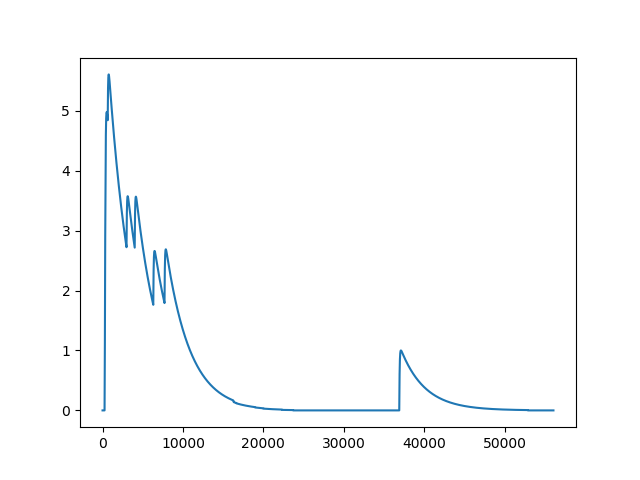

In [38]:
timestamp, accu_table, conv_table = TDC(100,-1,1)   # Event, Time Window for TDC, TE_TDC
print np.min(timestamp[np.argwhere(timestamp>0)])
fig = plt.figure()
plt.plot(conv_table[:,1366])


In [39]:
print accu_table[1000,1366]

6.0


In [40]:
time = 20000
first_SiPM = 1000
phi_o = np.zeros(Matrix_O.shape)
# Data Matrix Composition
for i in range(Matrix_O.shape[0]):
    for j in range(Matrix_O.shape[1]):
        phi_o[i,j] = accu_table[time,int(Matrix_O[i,j])]

<IPython.core.display.Javascript object>


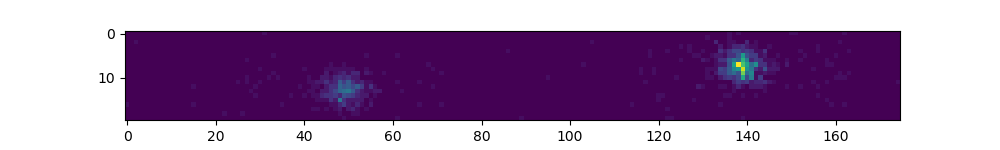

1190.0


In [41]:
fig = plt.figure(figsize=(10,1.5))
plt.imshow(phi_o)
plt.show()
print np.min(timestamp[np.argwhere(timestamp>0)])*5

# TOF computation

In [42]:
def TOF_comp(time_window, TE_TDC):
    t_stamp_v = np.array([]).reshape(0,3500)
    ring_dim     = Matrix_O.shape
    TOF = np.array([])
    j=0
    print("Mi TE_TDC es = %d" % TE_TDC)
    for i in range(10,3550):
        timestamp, part_acc, conv_table  = TDC(i,time_window,TE_TDC)
        print ("Process Event : %d" % i)
        t_stamp_v = np.vstack([t_stamp_v,timestamp])

        timestamp_M    = np.ma.MaskedArray(timestamp,timestamp<1)
        gamma1_sipm    = np.ma.argmin(timestamp_M)
        gamma1_tdc     = np.ma.min(timestamp_M)
        gamma2_sipm    = np.zeros(gamma1_sipm.shape)
        gamma2_tdc     = np.zeros(gamma1_sipm.shape)

        gamma1_coord = np.where(Matrix_O==gamma1_sipm)
        print ("Gamma 1 SiPM : %d" % Matrix_O[gamma1_coord])

        # Roll SiPM Matrixes to find opposite side of detector
        Xe = np.roll(Matrix_O,-gamma1_coord[1]+ring_dim[1]//4,axis=1)
        # Select opposite side of detector
        Xe_sel = Xe[:,ring_dim[1]//2:]
        Xe_sel_1D = Xe_sel.reshape(-1)
        try:
            OPO_g = timestamp_M[Xe_sel_1D]
            gamma2_tdc = np.ma.min(OPO_g)
            gamma2_coord = Xe_sel_1D[np.ma.argmin(OPO_g)]
            print ("Gamma 2 SiPM : %d" % gamma2_coord)
        except:
            gamma2_tdc = 0

        # Get rid of singles
        TOF_p = (gamma1_tdc - gamma2_tdc)/2
        if np.logical_not(np.isnan(TOF_p)):
            TOF = np.append(TOF,TOF_p)
            print gamma1_tdc, gamma2_tdc, TOF_p
            j += 1
        
    # Introduce a random sign to symmetrize distribution
    random_sign = (np.random.rand(len(TOF))>0.5)*-1
    random_sign = random_sign + random_sign + 1
    TOF = TOF * random_sign  
    
    return TOF
    

In [43]:
Test = TOF_comp(1000,2)

Mi TE_TDC es = 2
Process Event : 10
Gamma 1 SiPM : 297
Gamma 2 SiPM : 166
Process Event : 11
Gamma 1 SiPM : 2690
Gamma 2 SiPM : 109
Process Event : 12
Gamma 1 SiPM : 3436
Gamma 2 SiPM : 155
Process Event : 13
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 14
Gamma 1 SiPM : 1665
Gamma 2 SiPM : 134
Process Event : 15
Gamma 1 SiPM : 3460
Gamma 2 SiPM : 4
Process Event : 16
Gamma 1 SiPM : 3065
Gamma 2 SiPM : 134
Process Event : 17
Gamma 1 SiPM : 2386
Gamma 2 SiPM : 155
Process Event : 18
Gamma 1 SiPM : 1849
Gamma 2 SiPM : 143
Process Event : 19
Gamma 1 SiPM : 2612
Gamma 2 SiPM : 1300
229.0 645.0 -208.0
Process Event : 20
Gamma 1 SiPM : 576
Gamma 2 SiPM : 95
Process Event : 21
Gamma 1 SiPM : 2001
Gamma 2 SiPM : 120
Process Event : 22
Gamma 1 SiPM : 2830
Gamma 2 SiPM : 74
Process Event : 23
Gamma 1 SiPM : 2580
Gamma 2 SiPM : 174
Process Event : 24
Gamma 1 SiPM : 2198
Gamma 2 SiPM : 142
Process Event : 25
Gamma 1 SiPM : 2096
Gamma 2 SiPM : 40
Process Event : 26
Gamma 1 SiPM : 1554
Gamma 2

KeyboardInterrupt: 

In [ ]:
# Multiprocessing

def TOF_comp_wrapper(args):
    return TOF_comp(*args)

pool_size = mp.cpu_count() 
pool = mp.Pool(processes=pool_size)
#pool_output = pool.map(DAQ_map, [i for i in L1_Slice])
pool_output = pool.map(TOF_comp_wrapper, it.izip(it.repeat(10000),[i for i in np.arange(1,4,0.5)]))
pool.close()
pool.join()

Mi TE_TDC es = 1
Mi TE_TDC es = 1
Mi TE_TDC es = 2
Mi TE_TDC es = 2
Mi TE_TDC es = 3
Mi TE_TDC es = 3
Process Event : 10
Gamma 1 SiPM : 297
Gamma 2 SiPM : 166
Process Event : 10
Gamma 1 SiPM : 297
Gamma 2 SiPM : 166
Process Event : 10
Gamma 1 SiPM : 469
Gamma 2 SiPM : 163
Process Event : 10
Gamma 1 SiPM : 297
Gamma 2 SiPM : 166
Process Event : 10
Gamma 1 SiPM : 469
Gamma 2 SiPM : 163
Process Event : 10
Gamma 1 SiPM : 297
Gamma 2 SiPM : 166
Process Event : 11
Gamma 1 SiPM : 2690
Gamma 2 SiPM : 109
Process Event : 11
Gamma 1 SiPM : 2690
Gamma 2 SiPM : 109
Process Event : 11
Gamma 1 SiPM : 2690
Gamma 2 SiPM : 109
Process Event : 11
Gamma 1 SiPM : 2690
Process Event : 11
Gamma 2 SiPM : 637
Gamma 1 SiPM : 2690
Gamma 2 SiPM : 109
188.0 3887.0 -1849.5
Process Event : 11
Gamma 1 SiPM : 2690
Gamma 2 SiPM : 109
Process Event : 12
Gamma 1 SiPM : 3261
Gamma 2 SiPM : 155
Process Event : 12
Gamma 1 SiPM : 3436
Gamma 2 SiPM : 155
Process Event : 12
Gamma 1 SiPM : 3436
Gamma 2 SiPM : 155
Process Event

Gamma 1 SiPM : 1237
Gamma 2 SiPM : 56
Process Event : 34
Gamma 1 SiPM : 230
Gamma 2 SiPM : 2769
279.0 576.0 -148.5
Process Event : 32
Gamma 1 SiPM : 3267
Gamma 2 SiPM : 161
Process Event : 33
Gamma 1 SiPM : 2445
Gamma 2 SiPM : 39
Process Event : 33
Gamma 1 SiPM : 2794
Gamma 2 SiPM : 38
Process Event : 32
Gamma 1 SiPM : 3267
Gamma 2 SiPM : 161
Process Event : 35
Gamma 1 SiPM : 2405
Gamma 2 SiPM : 389
315.0 358.0 -21.5
Process Event : 32
Gamma 1 SiPM : 3090
Gamma 2 SiPM : 159
Process Event : 34
Gamma 1 SiPM : 407
Gamma 2 SiPM : 2597
240.0 317.0 -38.5
Process Event : 33
Gamma 1 SiPM : 2794
Gamma 2 SiPM : 38
Process Event : 33
Gamma 1 SiPM : 2794
Gamma 2 SiPM : 38
Process Event : 34
Gamma 1 SiPM : 230
Gamma 2 SiPM : 2769
296.0 595.0 -149.5
Process Event : 36
Gamma 1 SiPM : 955
Gamma 2 SiPM : 124
Process Event : 33
Gamma 1 SiPM : 2445
Gamma 2 SiPM : 39
Process Event : 35
Gamma 1 SiPM : 2405
Gamma 2 SiPM : 1089
268.0 286.0 -9.0
Process Event : 34
Gamma 1 SiPM : 407
Gamma 2 SiPM : 2769
258.0 

Gamma 2 SiPM : 3061
199.0 336.0 -68.5
Process Event : 55
Gamma 1 SiPM : 2744
Gamma 2 SiPM : 163
Process Event : 54
Gamma 1 SiPM : 1560
Gamma 2 SiPM : 2886
171.0 219.0 -24.0
Process Event : 57
Gamma 1 SiPM : 867
Gamma 2 SiPM : 36
Process Event : 58
Gamma 1 SiPM : 21
Gamma 2 SiPM : 2206
297.0 406.0 -54.5
Process Event : 56
Gamma 1 SiPM : 2790
Gamma 2 SiPM : 34
Process Event : 55
Gamma 1 SiPM : 2744
Gamma 2 SiPM : 163
Process Event : 55
Gamma 1 SiPM : 2744
Gamma 2 SiPM : 163
Process Event : 55
Gamma 1 SiPM : 2744
Gamma 2 SiPM : 163
Process Event : 56
Gamma 1 SiPM : 2790
Gamma 2 SiPM : 34
Process Event : 58
Gamma 1 SiPM : 21
Gamma 2 SiPM : 2908
242.0 295.0 -26.5
Process Event : 57
Gamma 1 SiPM : 868
Gamma 2 SiPM : 37
Process Event : 59
Gamma 1 SiPM : 806
Gamma 2 SiPM : 898
243.0 244.0 -0.5
Process Event : 56
Gamma 1 SiPM : 2440
Gamma 2 SiPM : 34
Process Event : 56
Gamma 1 SiPM : 2790
Gamma 2 SiPM : 34
Process Event : 59
Gamma 1 SiPM : 631
Gamma 2 SiPM : 898
203.0 224.0 -10.5
Process Event 

Gamma 2 SiPM : 110
Process Event : 78
Gamma 1 SiPM : 3174
Gamma 2 SiPM : 68
Process Event : 80
Gamma 1 SiPM : 1167
Gamma 2 SiPM : 161
Process Event : 76
Gamma 1 SiPM : 767
Gamma 2 SiPM : 111
Process Event : 78
Gamma 1 SiPM : 2823
Gamma 2 SiPM : 67
Process Event : 81
Gamma 1 SiPM : 27
Gamma 2 SiPM : 71
Process Event : 79
Gamma 1 SiPM : 3450
Gamma 2 SiPM : 169
Process Event : 77
Gamma 1 SiPM : 3477
Gamma 2 SiPM : 21
Process Event : 81
Gamma 1 SiPM : 204
Gamma 2 SiPM : 73
Process Event : 77
Gamma 1 SiPM : 2956
Gamma 2 SiPM : 25
Process Event : 80
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 79
Gamma 1 SiPM : 3450
Gamma 2 SiPM : 169
Process Event : 78
Gamma 1 SiPM : 2823
Gamma 2 SiPM : 813
896.0 3814.0 -1459.0
Process Event : 82
Gamma 1 SiPM : 1079
Gamma 2 SiPM : 73
Process Event : 82
Gamma 1 SiPM : 1956
Gamma 2 SiPM : 75
Process Event : 80
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 81
Gamma 1 SiPM : 27
Gamma 2 SiPM : 71
Process Event : 83
Gamma 1 SiPM : 3286
Gamma 2 SiPM : 5

Gamma 2 SiPM : 2499
338.0 1198.0 -430.0
Process Event : 101
Gamma 1 SiPM : 510
Gamma 2 SiPM : 29
Process Event : 98
Gamma 1 SiPM : 1467
Gamma 2 SiPM : 111
Process Event : 100
Gamma 1 SiPM : 1366
Gamma 2 SiPM : 2152
308.0 742.0 -217.0
Process Event : 103
Gamma 1 SiPM : 3490
Gamma 2 SiPM : 34
Process Event : 102
Gamma 1 SiPM : 1665
Gamma 2 SiPM : 134
Process Event : 101
Gamma 1 SiPM : 510
Gamma 2 SiPM : 29
Process Event : 102
Gamma 1 SiPM : 2190
Gamma 2 SiPM : 134
Process Event : 104
Gamma 1 SiPM : 341
Gamma 2 SiPM : 35
Process Event : 103
Gamma 1 SiPM : 3490
Gamma 2 SiPM : 34
Process Event : 99
Gamma 1 SiPM : 235
Gamma 2 SiPM : 104
Process Event : 101
Gamma 1 SiPM : 510
Gamma 2 SiPM : 29
Process Event : 102
Gamma 1 SiPM : 2190
Gamma 2 SiPM : 134
Process Event : 105
Gamma 1 SiPM : 827
Gamma 2 SiPM : 2491
409.0 2608.0 -1099.5
Process Event : 103
Gamma 1 SiPM : 3313
Gamma 2 SiPM : 32
Process Event : 104
Gamma 1 SiPM : 341
Gamma 2 SiPM : 35
Process Event : 100
Gamma 1 SiPM : 2499
Gamma 2 Si

Gamma 2 SiPM : 158
Process Event : 123
Gamma 1 SiPM : 3465
Gamma 2 SiPM : 9
Process Event : 125
Gamma 1 SiPM : 1205
Gamma 2 SiPM : 24
Process Event : 125
Gamma 1 SiPM : 1207
Gamma 2 SiPM : 26
Process Event : 125
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 121
Gamma 1 SiPM : 1164
Gamma 2 SiPM : 158
Process Event : 124
Gamma 1 SiPM : 1208
Gamma 2 SiPM : 27
Process Event : 122
Gamma 1 SiPM : 56
Gamma 2 SiPM : 100
Process Event : 126
Gamma 1 SiPM : 2570
Gamma 2 SiPM : 164
Process Event : 126
Gamma 1 SiPM : 2570
Gamma 2 SiPM : 164
Process Event : 126
Gamma 1 SiPM : 2397
Gamma 2 SiPM : 166
Process Event : 122
Gamma 1 SiPM : 408
Gamma 2 SiPM : 102
Process Event : 123
Gamma 1 SiPM : 3465
Gamma 2 SiPM : 9
Process Event : 125
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 127
Gamma 1 SiPM : 1260
Gamma 2 SiPM : 79
Process Event : 127
Gamma 1 SiPM : 1260
Gamma 2 SiPM : 79
Process Event : 123
Gamma 1 SiPM : 3465
Gamma 2 SiPM : 9
Process Event : 127
Gamma 1 SiPM : 1260
Gamma 2 SiPM : 79
P

Gamma 1 SiPM : 2708
Gamma 2 SiPM : 127
Process Event : 148
Gamma 1 SiPM : 706
Gamma 2 SiPM : 50
Process Event : 146
Gamma 1 SiPM : 2726
Gamma 2 SiPM : 145
Process Event : 144
Gamma 1 SiPM : 2378
Gamma 2 SiPM : 147
Process Event : 144
Gamma 1 SiPM : 3078
Gamma 2 SiPM : 147
Process Event : 148
Gamma 1 SiPM : 706
Gamma 2 SiPM : 50
Process Event : 148
Gamma 1 SiPM : 1054
Gamma 2 SiPM : 48
Process Event : 147
Gamma 1 SiPM : 2708
Gamma 2 SiPM : 127
Process Event : 149
Gamma 1 SiPM : 1198
Gamma 2 SiPM : 17
Process Event : 145
Gamma 1 SiPM : 2031
Gamma 2 SiPM : 1766
251.0 542.0 -145.5
Process Event : 145
Gamma 1 SiPM : 2031
Gamma 2 SiPM : 1768
222.0 354.0 -66.0
Process Event : 149
Process Event : 149
Gamma 1 SiPM : 1201
Gamma 1 SiPM : 848
Gamma 2 SiPM : 20
Gamma 2 SiPM : 17
Process Event : 150
Gamma 1 SiPM : 3026
Gamma 2 SiPM : 95
Process Event : 148
Gamma 1 SiPM : 706
Gamma 2 SiPM : 50
Process Event : 150
Gamma 1 SiPM : 3026
Gamma 2 SiPM : 95
Process Event : 146
Gamma 1 SiPM : 3078
Gamma 2 Si

Process Event : 166
Gamma 1 SiPM : 1937
Gamma 2 SiPM : 56
Process Event : 171
Gamma 1 SiPM : 3407
Gamma 2 SiPM : 171
188.0 269.0 -40.5
Process Event : 170
Gamma 1 SiPM : 1127
Gamma 2 SiPM : 121
Process Event : 171
Gamma 1 SiPM : 3407
Gamma 2 SiPM : 345
199.0 329.0 -65.0
Process Event : 170
Gamma 1 SiPM : 1127
Gamma 2 SiPM : 121
Process Event : 167
Gamma 1 SiPM : 1353
Gamma 2 SiPM : 172
Process Event : 172
Gamma 1 SiPM : 1193
Gamma 2 SiPM : 12
Process Event : 166
Gamma 1 SiPM : 1762
Gamma 2 SiPM : 56
Process Event : 171
Gamma 1 SiPM : 3407
Gamma 2 SiPM : 345
208.0 374.0 -83.0
Process Event : 172
Gamma 1 SiPM : 1018
Gamma 2 SiPM : 12
Process Event : 171
Gamma 1 SiPM : 3407
Gamma 2 SiPM : 345
203.0 346.0 -71.5
Process Event : 167
Gamma 1 SiPM : 1353
Gamma 2 SiPM : 172
Process Event : 168
Gamma 1 SiPM : 2736
Gamma 2 SiPM : 155
Process Event : 173
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 173
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 172
Gamma 1 SiPM : 1018
Gamma 2 SiPM : 

Process Event : 193
Gamma 1 SiPM : 302
Gamma 2 SiPM : 171
Process Event : 190
Gamma 1 SiPM : 2287
Gamma 2 SiPM : 56
Process Event : 195
Gamma 1 SiPM : 1046
Gamma 2 SiPM : 40
Process Event : 193
Gamma 1 SiPM : 302
Gamma 2 SiPM : 171
Process Event : 189
Gamma 1 SiPM : 664
Gamma 2 SiPM : 8
Process Event : 194
Gamma 1 SiPM : 771
Gamma 2 SiPM : 115
Process Event : 194
Gamma 1 SiPM : 771
Gamma 2 SiPM : 115
Process Event : 191
Gamma 1 SiPM : 1705
Gamma 2 SiPM : 174
Process Event : 196
Gamma 1 SiPM : 2516
Gamma 2 SiPM : 110
Process Event : 194
Gamma 1 SiPM : 770
Gamma 2 SiPM : 114
Process Event : 195
Gamma 1 SiPM : 1046
Gamma 2 SiPM : 40
Process Event : 190
Gamma 1 SiPM : 2287
Gamma 2 SiPM : 56
Process Event : 195
Gamma 1 SiPM : 872
Gamma 2 SiPM : 41
Process Event : 197
Gamma 1 SiPM : 2111
Gamma 2 SiPM : 55
Process Event : 195
Gamma 1 SiPM : 872
Gamma 2 SiPM : 41
Process Event : 196
Gamma 1 SiPM : 3392
Gamma 2 SiPM : 111
Process Event : 192
Gamma 1 SiPM : 3229
Gamma 2 SiPM : 123
Process Event 

Gamma 2 SiPM : 21
Process Event : 216
Gamma 1 SiPM : 3483
Gamma 2 SiPM : 27
Process Event : 216
Gamma 1 SiPM : 3485
Gamma 2 SiPM : 29
Process Event : 211
Gamma 1 SiPM : 2450
Gamma 2 SiPM : 44
Process Event : 218
Gamma 1 SiPM : 3330
Gamma 2 SiPM : 2886
201.0 219.0 -9.0
Process Event : 212
Gamma 1 SiPM : 748
Gamma 2 SiPM : 92
Process Event : 216
Gamma 1 SiPM : 3485
Gamma 2 SiPM : 29
Process Event : 217
Gamma 1 SiPM : 2134
Gamma 2 SiPM : 78
Process Event : 217
Gamma 1 SiPM : 1940
Gamma 2 SiPM : 59
Process Event : 212
Gamma 1 SiPM : 1095
Gamma 2 SiPM : 89
Process Event : 219
Gamma 1 SiPM : 2966
Gamma 2 SiPM : 35
Process Event : 213
Gamma 1 SiPM : 2578
Gamma 2 SiPM : 172
Process Event : 217
Gamma 1 SiPM : 1940
Gamma 2 SiPM : 59
Process Event : 218
Gamma 1 SiPM : 3330
Gamma 2 SiPM : 2886
190.0 209.0 -9.5
Process Event : 218
Gamma 1 SiPM : 3330
Gamma 2 SiPM : 2886
208.0 223.0 -7.5
Process Event : 213
Gamma 1 SiPM : 2578
Gamma 2 SiPM : 525
233.0 5256.0 -2511.5
Process Event : 220
Gamma 1 SiPM 

Gamma 2 SiPM : 70
Process Event : 240
Gamma 1 SiPM : 1728
Gamma 2 SiPM : 22
Process Event : 235
Gamma 1 SiPM : 1199
Gamma 2 SiPM : 18
Process Event : 234
Gamma 1 SiPM : 786
Gamma 2 SiPM : 130
Process Event : 238
Gamma 1 SiPM : 1426
Gamma 2 SiPM : 70
Process Event : 241
Gamma 1 SiPM : 285
Gamma 2 SiPM : 154
Process Event : 239
Gamma 1 SiPM : 2747
Gamma 2 SiPM : 906
322.0 373.0 -25.5
Process Event : 239
Gamma 1 SiPM : 2747
Gamma 2 SiPM : 906
350.0 403.0 -26.5
Process Event : 236
Gamma 1 SiPM : 2415
Gamma 2 SiPM : 9
Process Event : 235
Gamma 1 SiPM : 1200
Gamma 2 SiPM : 19
Process Event : 240
Gamma 1 SiPM : 1728
Gamma 2 SiPM : 22
Process Event : 240
Gamma 1 SiPM : 1728
Gamma 2 SiPM : 22
Process Event : 239
Gamma 1 SiPM : 1082
Gamma 2 SiPM : 2747
252.0 282.0 -15.0
Process Event : 242
Gamma 1 SiPM : 2559
Gamma 2 SiPM : 153
Process Event : 237
Gamma 1 SiPM : 195
Gamma 2 SiPM : 64
Process Event : 236
Gamma 1 SiPM : 2415
Gamma 2 SiPM : 9
Process Event : 241
Gamma 1 SiPM : 285
Gamma 2 SiPM : 15

Process Event : 257
Gamma 1 SiPM : 2148
Gamma 2 SiPM : 92
Process Event : 259
Gamma 1 SiPM : 1460
Gamma 2 SiPM : 104
Process Event : 261
Gamma 1 SiPM : 2022
Gamma 2 SiPM : 141
Process Event : 263
Gamma 1 SiPM : 1344
Gamma 2 SiPM : 163
Process Event : 257
Gamma 1 SiPM : 2148
Gamma 2 SiPM : 92
Process Event : 262
Gamma 1 SiPM : 949
Gamma 2 SiPM : 118
Process Event : 263
Gamma 1 SiPM : 644
Gamma 2 SiPM : 163
Process Event : 258
Gamma 1 SiPM : 2757
Gamma 2 SiPM : 1
Process Event : 260
Gamma 1 SiPM : 2995
Gamma 2 SiPM : 64
Process Event : 264
Gamma 1 SiPM : 419
Gamma 2 SiPM : 113
Process Event : 258
Gamma 1 SiPM : 2233
Gamma 2 SiPM : 2
Process Event : 263
Gamma 1 SiPM : 1344
Gamma 2 SiPM : 163
Process Event : 259
Gamma 1 SiPM : 1460
Gamma 2 SiPM : 104
Process Event : 264
Gamma 1 SiPM : 241
Gamma 2 SiPM : 110
Process Event : 259
Gamma 1 SiPM : 1460
Gamma 2 SiPM : 104
Process Event : 261
Gamma 1 SiPM : 2022
Gamma 2 SiPM : 2805
169.0 6605.0 -3218.0
Process Event : 265
Gamma 1 SiPM : 2609
Gamma

Gamma 2 SiPM : 2901
887.0 931.0 -22.0
Process Event : 285
Gamma 1 SiPM : 3242
Gamma 2 SiPM : 136
Process Event : 281
Gamma 1 SiPM : 212
Gamma 2 SiPM : 81
Process Event : 287
Gamma 1 SiPM : 741
Gamma 2 SiPM : 1500
390.0 500.0 -55.0
Process Event : 284
Gamma 1 SiPM : 1472
Gamma 2 SiPM : 116
Process Event : 281
Gamma 1 SiPM : 212
Gamma 2 SiPM : 81
Process Event : 282
Gamma 1 SiPM : 1088
Gamma 2 SiPM : 82
Process Event : 282
Gamma 1 SiPM : 737
Gamma 2 SiPM : 81
Process Event : 286
Gamma 1 SiPM : 2388
Gamma 2 SiPM : 157
Process Event : 288
Gamma 1 SiPM : 3443
Gamma 2 SiPM : 162
Process Event : 285
Gamma 1 SiPM : 3240
Gamma 2 SiPM : 134
Process Event : 282
Gamma 1 SiPM : 1088
Gamma 2 SiPM : 82
Process Event : 283
Gamma 1 SiPM : 2729
Gamma 2 SiPM : 15
321.0 368.0 -23.5
Process Event : 283
Gamma 1 SiPM : 2729
Gamma 2 SiPM : 188
356.0 505.0 -74.5
Process Event : 286
Gamma 1 SiPM : 2213
Gamma 2 SiPM : 157
Process Event : 287
Gamma 1 SiPM : 915
Gamma 2 SiPM : 1500
301.0 361.0 -30.0
Process Event 

224.0 295.0 -35.5
Process Event : 306
Gamma 1 SiPM : 1513
Gamma 2 SiPM : 157
Process Event : 308
Gamma 1 SiPM : 1395
Gamma 2 SiPM : 39
Process Event : 309
Gamma 1 SiPM : 3142
Gamma 2 SiPM : 36
Process Event : 303
Gamma 1 SiPM : 2902
Gamma 2 SiPM : 146
Process Event : 303
Gamma 1 SiPM : 3254
Gamma 2 SiPM : 148
Process Event : 307
Gamma 1 SiPM : 2846
Gamma 2 SiPM : 90
Process Event : 309
Gamma 1 SiPM : 3142
Gamma 2 SiPM : 36
Process Event : 305
Gamma 1 SiPM : 3279
Gamma 2 SiPM : 173
Process Event : 304
Gamma 1 SiPM : 2547
Gamma 2 SiPM : 1767
241.0 405.0 -82.0
Process Event : 310
Gamma 1 SiPM : 2210
Gamma 2 SiPM : 154
Process Event : 304
Gamma 1 SiPM : 2547
Gamma 2 SiPM : 1767
195.0 265.0 -35.0
Process Event : 308
Gamma 1 SiPM : 1395
Gamma 2 SiPM : 39
Process Event : 306
Gamma 1 SiPM : 1513
Gamma 2 SiPM : 157
Process Event : 310
Gamma 1 SiPM : 2035
Gamma 2 SiPM : 154
Process Event : 305
Gamma 1 SiPM : 3279
Gamma 2 SiPM : 173
Process Event : 311
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process E

Gamma 1 SiPM : 2925
Gamma 2 SiPM : 169
Process Event : 326
Gamma 1 SiPM : 2972
Gamma 2 SiPM : 41
Process Event : 331
Gamma 1 SiPM : 2788
Gamma 2 SiPM : 32
Process Event : 329
Gamma 1 SiPM : 2492
Gamma 2 SiPM : 86
Process Event : 326
Gamma 1 SiPM : 2972
Gamma 2 SiPM : 41
Process Event : 328
Gamma 1 SiPM : 690
Gamma 2 SiPM : 34
Process Event : 327
Gamma 1 SiPM : 2669
Gamma 2 SiPM : 88
Process Event : 332
Gamma 1 SiPM : 2697
Gamma 2 SiPM : 116
Process Event : 331
Gamma 1 SiPM : 2612
Gamma 2 SiPM : 31
Process Event : 327
Gamma 1 SiPM : 2669
Gamma 2 SiPM : 88
Process Event : 330
Gamma 1 SiPM : 1019
Gamma 2 SiPM : 13
Process Event : 329
Gamma 1 SiPM : 2492
Gamma 2 SiPM : 830
176.0 2080.0 -952.0
Process Event : 328
Gamma 1 SiPM : 692
Gamma 2 SiPM : 36
Process Event : 332
Gamma 1 SiPM : 2697
Gamma 2 SiPM : 116
Process Event : 328
Gamma 1 SiPM : 690
Gamma 2 SiPM : 34
Process Event : 331
Gamma 1 SiPM : 2788
Gamma 2 SiPM : 32
Process Event : 333
Gamma 1 SiPM : 1602
Gamma 2 SiPM : 71
Process Event

Gamma 2 SiPM : 5
Process Event : 351
Gamma 1 SiPM : 181
Gamma 2 SiPM : 3061
253.0 332.0 -39.5
Process Event : 351
Gamma 1 SiPM : 181
Gamma 2 SiPM : 2888
235.0 288.0 -26.5
Process Event : 353
Gamma 1 SiPM : 501
Gamma 2 SiPM : 3213
320.0 496.0 -88.0
Process Event : 353
Gamma 1 SiPM : 501
Gamma 2 SiPM : 3213
337.0 951.0 -307.0
Process Event : 354
Gamma 1 SiPM : 1747
Gamma 2 SiPM : 1139
297.0 748.0 -225.5
Process Event : 348
Gamma 1 SiPM : 3145
Gamma 2 SiPM : 39
Process Event : 352
Gamma 1 SiPM : 1127
Gamma 2 SiPM : 121
Process Event : 352
Gamma 1 SiPM : 1127
Gamma 2 SiPM : 121
Process Event : 354
Gamma 1 SiPM : 1747
Gamma 2 SiPM : 2186
251.0 405.0 -77.0
Process Event : 355
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 349
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 354
Gamma 1 SiPM : 1747
Gamma 2 SiPM : 1139
269.0 712.0 -221.5
Process Event : 353
Gamma 1 SiPM : 674
Gamma 2 SiPM : 3213
260.0 396.0 -68.0
Process Event : 353
Gamma 1 SiPM : 501
Gamma 2 SiPM : 3213
307.0 466.0 -79.

Gamma 1 SiPM : 3288
Gamma 2 SiPM : 747
292.0 355.0 -31.5
Process Event : 375
Gamma 1 SiPM : 3288
Gamma 2 SiPM : 747
309.0 491.0 -91.0
Process Event : 369
Gamma 1 SiPM : 1289
Gamma 2 SiPM : 108
Process Event : 376
Gamma 1 SiPM : 2428
Gamma 2 SiPM : 22
Process Event : 376
Gamma 1 SiPM : 2077
Gamma 2 SiPM : 21
Process Event : 373
Gamma 1 SiPM : 740
Gamma 2 SiPM : 84
Process Event : 377
Gamma 1 SiPM : 1568
Gamma 2 SiPM : 37
Process Event : 370
Gamma 1 SiPM : 2835
Gamma 2 SiPM : 79
Process Event : 376
Gamma 1 SiPM : 2428
Gamma 2 SiPM : 22
Process Event : 377
Gamma 1 SiPM : 1568
Gamma 2 SiPM : 37
Process Event : 375
Gamma 1 SiPM : 3288
Gamma 2 SiPM : 747
269.0 326.0 -28.5
Process Event : 378
Gamma 1 SiPM : 658
Gamma 2 SiPM : 2
Process Event : 371
Gamma 1 SiPM : 2212
Gamma 2 SiPM : 156
Process Event : 374
Gamma 1 SiPM : 2935
Gamma 2 SiPM : 4
Process Event : 378
Gamma 1 SiPM : 658
Gamma 2 SiPM : 2
Process Event : 377
Gamma 1 SiPM : 1568
Gamma 2 SiPM : 37
Process Event : 376
Gamma 1 SiPM : 2077

Gamma 1 SiPM : 2373
Gamma 2 SiPM : 180
217.0 336.0 -59.5
Process Event : 398
Gamma 1 SiPM : 1461
Gamma 2 SiPM : 105
Process Event : 396
Gamma 1 SiPM : 2944
Gamma 2 SiPM : 13
Process Event : 398
Gamma 1 SiPM : 1461
Gamma 2 SiPM : 105
Process Event : 392
Gamma 1 SiPM : 1947
Gamma 2 SiPM : 66
Process Event : 397
Gamma 1 SiPM : 2880
Gamma 2 SiPM : 124
Process Event : 397
Gamma 1 SiPM : 2880
Gamma 2 SiPM : 124
Process Event : 399
Gamma 1 SiPM : 2361
Gamma 2 SiPM : 130
Process Event : 399
Gamma 1 SiPM : 2361
Gamma 2 SiPM : 130
Process Event : 395
Gamma 1 SiPM : 1909
Gamma 2 SiPM : 28
Process Event : 393
Gamma 1 SiPM : 3124
Gamma 2 SiPM : 18
Process Event : 398
Gamma 1 SiPM : 1461
Gamma 2 SiPM : 105
Process Event : 400
Gamma 1 SiPM : 3437
Gamma 2 SiPM : 156
Process Event : 400
Gamma 1 SiPM : 3085
Gamma 2 SiPM : 154
Process Event : 398
Gamma 1 SiPM : 1461
Gamma 2 SiPM : 105
Process Event : 396
Gamma 1 SiPM : 2944
Gamma 2 SiPM : 13
Process Event : 394
Gamma 1 SiPM : 2373
Gamma 2 SiPM : 180
204.

Gamma 1 SiPM : 98
Gamma 2 SiPM : 142
Process Event : 414
Gamma 1 SiPM : 3181
Gamma 2 SiPM : 75
Process Event : 418
Gamma 1 SiPM : 1171
Gamma 2 SiPM : 165
Process Event : 418
Gamma 1 SiPM : 1171
Gamma 2 SiPM : 165
Process Event : 421
Gamma 1 SiPM : 494
Gamma 2 SiPM : 2141
407.0 692.0 -142.5
Process Event : 421
Gamma 1 SiPM : 320
Gamma 2 SiPM : 1961
361.0 413.0 -26.0
Process Event : 419
Gamma 1 SiPM : 3370
Gamma 2 SiPM : 89
Process Event : 421
Gamma 1 SiPM : 494
Gamma 2 SiPM : 2141
379.0 654.0 -137.5
Process Event : 422
Gamma 1 SiPM : 2647
Gamma 2 SiPM : 66
Process Event : 419
Gamma 1 SiPM : 3019
Gamma 2 SiPM : 88
Process Event : 415
Gamma 1 SiPM : 3497
Gamma 2 SiPM : 95
223.0 303.0 -40.0
Process Event : 422
Gamma 1 SiPM : 2647
Gamma 2 SiPM : 66
Process Event : 420
Gamma 1 SiPM : 621
Gamma 2 SiPM : 140
Process Event : 420
Gamma 1 SiPM : 276
Gamma 2 SiPM : 145
Process Event : 423
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 422
Gamma 1 SiPM : 2647
Gamma 2 SiPM : 66
Process Event : 4

Process Event : 435
Gamma 1 SiPM : 1627
Gamma 2 SiPM : 96
Process Event : 443
Gamma 1 SiPM : 3226
Gamma 2 SiPM : 120
Process Event : 443
Gamma 1 SiPM : 3226
Gamma 2 SiPM : 120
Process Event : 441
Gamma 1 SiPM : 2112
Gamma 2 SiPM : 439
215.0 350.0 -67.5
Process Event : 436
Gamma 1 SiPM : 2156
Gamma 2 SiPM : 100
Process Event : 441
Gamma 1 SiPM : 2112
Gamma 2 SiPM : 258
312.0 795.0 -241.5
Process Event : 444
Gamma 1 SiPM : 1909
Gamma 2 SiPM : 28
Process Event : 442
Gamma 1 SiPM : 1896
Gamma 2 SiPM : 15
Process Event : 444
Gamma 1 SiPM : 1909
Gamma 2 SiPM : 28
Process Event : 442
Gamma 1 SiPM : 1896
Gamma 2 SiPM : 15
Process Event : 437
Gamma 1 SiPM : 1429
Gamma 2 SiPM : 73
Process Event : 443
Gamma 1 SiPM : 3226
Gamma 2 SiPM : 120
Process Event : 442
Gamma 1 SiPM : 1895
Gamma 2 SiPM : 14
Process Event : 443
Gamma 1 SiPM : 3226
Gamma 2 SiPM : 120
Process Event : 445
Gamma 1 SiPM : 2772
Gamma 2 SiPM : 16
Process Event : 445
Gamma 1 SiPM : 2244
Gamma 2 SiPM : 13
Process Event : 444
Gamma 1 

Gamma 1 SiPM : 2965
Gamma 2 SiPM : 34
Process Event : 464
Gamma 1 SiPM : 3484
Gamma 2 SiPM : 28
Process Event : 459
Gamma 1 SiPM : 1256
Gamma 2 SiPM : 75
Process Event : 466
Gamma 1 SiPM : 3318
Gamma 2 SiPM : 37
Process Event : 465
Gamma 1 SiPM : 2498
Gamma 2 SiPM : 92
Process Event : 465
Gamma 1 SiPM : 2502
Gamma 2 SiPM : 96
Process Event : 466
Gamma 1 SiPM : 2965
Gamma 2 SiPM : 34
Process Event : 465
Gamma 1 SiPM : 2498
Gamma 2 SiPM : 92
Process Event : 460
Gamma 1 SiPM : 3331
Gamma 2 SiPM : 50
Process Event : 466
Gamma 1 SiPM : 3493
Gamma 2 SiPM : 37
Process Event : 467
Gamma 1 SiPM : 2988
Gamma 2 SiPM : 57
Process Event : 467
Gamma 1 SiPM : 2814
Gamma 2 SiPM : 58
Process Event : 461
Gamma 1 SiPM : 1481
Gamma 2 SiPM : 125
Process Event : 467
Gamma 1 SiPM : 2988
Gamma 2 SiPM : 57
Process Event : 468
Gamma 1 SiPM : 949
Gamma 2 SiPM : 118
Process Event : 466
Gamma 1 SiPM : 3318
Gamma 2 SiPM : 37
Process Event : 467
Gamma 1 SiPM : 2465
Gamma 2 SiPM : 59
Process Event : 468
Gamma 1 SiPM 

Gamma 1 SiPM : 3053
Gamma 2 SiPM : 122
Process Event : 488
Gamma 1 SiPM : 3050
Gamma 2 SiPM : 119
Process Event : 487
Gamma 1 SiPM : 984
Gamma 2 SiPM : 2300
2483.0 2772.0 -144.5
Process Event : 483
Gamma 1 SiPM : 2589
Gamma 2 SiPM : 8
Process Event : 489
Gamma 1 SiPM : 35
Gamma 2 SiPM : 79
Process Event : 489
Gamma 1 SiPM : 35
Gamma 2 SiPM : 79
Process Event : 488
Gamma 1 SiPM : 3226
Gamma 2 SiPM : 120
Process Event : 484
Gamma 1 SiPM : 1509
Gamma 2 SiPM : 153
Process Event : 489
Gamma 1 SiPM : 35
Gamma 2 SiPM : 79
Process Event : 489
Gamma 1 SiPM : 35
Gamma 2 SiPM : 79
Process Event : 488
Gamma 1 SiPM : 3050
Gamma 2 SiPM : 119
Process Event : 490
Gamma 1 SiPM : 2475
Gamma 2 SiPM : 69
Process Event : 485
Gamma 1 SiPM : 2810
Gamma 2 SiPM : 54
Process Event : 490
Gamma 1 SiPM : 2475
Gamma 2 SiPM : 69
Process Event : 490
Gamma 1 SiPM : 2475
Gamma 2 SiPM : 69
Process Event : 489
Gamma 1 SiPM : 35
Gamma 2 SiPM : 79
Process Event : 490
Gamma 1 SiPM : 2474
Gamma 2 SiPM : 68
Process Event : 49

Process Event : 507
Gamma 1 SiPM : 3111
Gamma 2 SiPM : 5
Process Event : 511
Gamma 1 SiPM : 585
Gamma 2 SiPM : 104
Process Event : 508
Gamma 1 SiPM : 115
Gamma 2 SiPM : 159
Process Event : 510
Gamma 1 SiPM : 677
Gamma 2 SiPM : 21
Process Event : 512
Gamma 1 SiPM : 1478
Gamma 2 SiPM : 122
Process Event : 511
Gamma 1 SiPM : 585
Gamma 2 SiPM : 104
Process Event : 508
Gamma 1 SiPM : 465
Gamma 2 SiPM : 159
Process Event : 512
Gamma 1 SiPM : 1478
Gamma 2 SiPM : 122
Process Event : 513
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 509
Gamma 1 SiPM : 1165
Gamma 2 SiPM : 2832
189.0 768.0 -289.5
Process Event : 511
Gamma 1 SiPM : 933
Gamma 2 SiPM : 102
Process Event : 512
Gamma 1 SiPM : 1478
Gamma 2 SiPM : 122
Process Event : 509
Gamma 1 SiPM : 1165
Gamma 2 SiPM : 2827
153.0 325.0 -86.0
Process Event : 514
Gamma 1 SiPM : 2509
Gamma 2 SiPM : 2416
305.0 340.0 -17.5
Process Event : 513
Gamma 1 SiPM : 1725
Gamma 2 SiPM : 19
Process Event : 510
Gamma 1 SiPM : 679
Gamma 2 SiPM : 23
Process Event 

Process Event : 531
Gamma 1 SiPM : 2222
Gamma 2 SiPM : 738
264.0 309.0 -22.5
Process Event : 531
Gamma 1 SiPM : 738
Gamma 2 SiPM : 2226
390.0 404.0 -7.0
Process Event : 529
Gamma 1 SiPM : 2704
Gamma 2 SiPM : 123
Process Event : 532
Gamma 1 SiPM : 496
Gamma 2 SiPM : 15
Process Event : 530
Gamma 1 SiPM : 2349
Gamma 2 SiPM : 118
Process Event : 532
Gamma 1 SiPM : 495
Gamma 2 SiPM : 14
Process Event : 532
Gamma 1 SiPM : 496
Gamma 2 SiPM : 15
Process Event : 536
Gamma 1 SiPM : 2173
Gamma 2 SiPM : 117
Process Event : 530
Gamma 1 SiPM : 2172
Gamma 2 SiPM : 116
Process Event : 531
Gamma 1 SiPM : 738
Gamma 2 SiPM : 2226
419.0 432.0 -6.5
Process Event : 533
Gamma 1 SiPM : 3457
Gamma 2 SiPM : 1
Process Event : 537
Gamma 1 SiPM : 1838
Gamma 2 SiPM : 132
Process Event : 533
Gamma 1 SiPM : 3278
Gamma 2 SiPM : 172
Process Event : 533
Gamma 1 SiPM : 3457
Gamma 2 SiPM : 1
Process Event : 531
Gamma 1 SiPM : 2222
Gamma 2 SiPM : 738
234.0 296.0 -31.0
Process Event : 532
Gamma 1 SiPM : 495
Gamma 2 SiPM : 1

Gamma 2 SiPM : 139
Process Event : 551
Gamma 1 SiPM : 2790
Gamma 2 SiPM : 34
Process Event : 554
Gamma 1 SiPM : 1053
Gamma 2 SiPM : 47
Process Event : 552
Gamma 1 SiPM : 2595
Gamma 2 SiPM : 1809
270.0 413.0 -71.5
Process Event : 558
Gamma 1 SiPM : 186
Gamma 2 SiPM : 55
Process Event : 554
Gamma 1 SiPM : 1053
Gamma 2 SiPM : 47
Process Event : 555
Gamma 1 SiPM : 3170
Gamma 2 SiPM : 64
Process Event : 552
Gamma 1 SiPM : 2595
Gamma 2 SiPM : 1806
205.0 258.0 -26.5
Process Event : 555
Gamma 1 SiPM : 2995
Gamma 2 SiPM : 64
Process Event : 553
Gamma 1 SiPM : 3495
Gamma 2 SiPM : 39
Process Event : 559
Gamma 1 SiPM : 3368
Gamma 2 SiPM : 87
Process Event : 556
Gamma 1 SiPM : 1367
Gamma 2 SiPM : 11
Process Event : 555
Gamma 1 SiPM : 2996
Gamma 2 SiPM : 65
Process Event : 553
Gamma 1 SiPM : 2443
Gamma 2 SiPM : 37
Process Event : 556
Gamma 1 SiPM : 1891
Gamma 2 SiPM : 10
Process Event : 554
Gamma 1 SiPM : 1053
Gamma 2 SiPM : 47
Process Event : 560
Gamma 1 SiPM : 1092
Gamma 2 SiPM : 86
Process Event 

Gamma 2 SiPM : 106
Process Event : 577
Gamma 1 SiPM : 631
Gamma 2 SiPM : 150
Process Event : 577
Gamma 1 SiPM : 456
Gamma 2 SiPM : 150
Process Event : 576
Gamma 1 SiPM : 1724
Gamma 2 SiPM : 1983
624.0 927.0 -151.5
Process Event : 580
Gamma 1 SiPM : 2519
Gamma 2 SiPM : 113
Process Event : 578
Gamma 1 SiPM : 699
Gamma 2 SiPM : 43
Process Event : 575
Gamma 1 SiPM : 1980
Gamma 2 SiPM : 99
Process Event : 574
Gamma 1 SiPM : 38
Gamma 2 SiPM : 82
Process Event : 578
Gamma 1 SiPM : 699
Gamma 2 SiPM : 43
Process Event : 581
Gamma 1 SiPM : 2718
Gamma 2 SiPM : 137
Process Event : 577
Gamma 1 SiPM : 280
Gamma 2 SiPM : 149
Process Event : 579
Gamma 1 SiPM : 3257
Gamma 2 SiPM : 1742
278.0 1370.0 -546.0
Process Event : 579
Gamma 1 SiPM : 3257
Gamma 2 SiPM : 1567
321.0 2195.0 -937.0
Process Event : 582
Gamma 1 SiPM : 386
Gamma 2 SiPM : 80
Process Event : 575
Gamma 1 SiPM : 1452
Gamma 2 SiPM : 96
Process Event : 576
Gamma 1 SiPM : 1724
Gamma 2 SiPM : 1983
656.0 962.0 -153.0
Process Event : 578
Gamma 1 

Process Event : 597
Gamma 1 SiPM : 3460
Gamma 2 SiPM : 4
Process Event : 604
Gamma 1 SiPM : 1191
Gamma 2 SiPM : 10
Process Event : 597
Gamma 1 SiPM : 3460
Gamma 2 SiPM : 4
Process Event : 600
Gamma 1 SiPM : 1404
Gamma 2 SiPM : 1136
206.0 493.0 -143.5
Process Event : 598
Gamma 1 SiPM : 2084
Gamma 2 SiPM : 28
Process Event : 598
Gamma 1 SiPM : 2084
Gamma 2 SiPM : 28
Process Event : 600
Gamma 1 SiPM : 1404
Gamma 2 SiPM : 1133
194.0 318.0 -62.0
Process Event : 605
Gamma 1 SiPM : 1023
Gamma 2 SiPM : 17
Process Event : 598
Gamma 1 SiPM : 2084
Gamma 2 SiPM : 28
Process Event : 601
Gamma 1 SiPM : 2642
Gamma 2 SiPM : 61
Process Event : 599
Gamma 1 SiPM : 3267
Gamma 2 SiPM : 161
Process Event : 599
Gamma 1 SiPM : 3267
Gamma 2 SiPM : 161
Process Event : 601
Gamma 1 SiPM : 2117
Gamma 2 SiPM : 61
Process Event : 606
Gamma 1 SiPM : 2772
Gamma 2 SiPM : 16
Process Event : 607
Gamma 1 SiPM : 3395
Process Event : 602
Gamma 1 SiPM : 175
Gamma 2 SiPM : 2888
Gamma 2 SiPM : 114
215.0 974.0 -379.5
Process Ev

222.0 768.0 -273.0
Process Event : 618
Gamma 1 SiPM : 2069
Gamma 2 SiPM : 1806
184.0 332.0 -74.0
Process Event : 621
Gamma 1 SiPM : 2531
Gamma 2 SiPM : 125
Process Event : 618
Gamma 1 SiPM : 2069
Gamma 2 SiPM : 1630
216.0 735.0 -259.5
Process Event : 619
Gamma 1 SiPM : 2087
Gamma 2 SiPM : 31
Process Event : 622
Gamma 1 SiPM : 1964
Gamma 2 SiPM : 83
Process Event : 629
Gamma 1 SiPM : 2156
Gamma 2 SiPM : 100
Process Event : 619
Gamma 1 SiPM : 2783
Gamma 2 SiPM : 27
Process Event : 619
Gamma 1 SiPM : 2087
Gamma 2 SiPM : 31
Process Event : 622
Gamma 1 SiPM : 1964
Gamma 2 SiPM : 83
Process Event : 620
Gamma 1 SiPM : 86
Gamma 2 SiPM : 130
Process Event : 630
Gamma 1 SiPM : 660
Gamma 2 SiPM : 4
Process Event : 623
Gamma 1 SiPM : 1818
Gamma 2 SiPM : 112
Process Event : 623
Gamma 1 SiPM : 1992
Gamma 2 SiPM : 111
Process Event : 620
Gamma 1 SiPM : 84
Gamma 2 SiPM : 128
Process Event : 620
Gamma 1 SiPM : 86
Gamma 2 SiPM : 130
Process Event : 621
Gamma 1 SiPM : 2357
Gamma 2 SiPM : 126
Process Even

Process Event : 642
Gamma 1 SiPM : 3097
Gamma 2 SiPM : 166
Process Event : 642
Gamma 1 SiPM : 3097
Gamma 2 SiPM : 166
Process Event : 645
Gamma 1 SiPM : 2985
Gamma 2 SiPM : 271
272.0 489.0 -108.5
Process Event : 643
Gamma 1 SiPM : 2022
Gamma 2 SiPM : 141
Process Event : 639
Gamma 1 SiPM : 299
Gamma 2 SiPM : 168
Process Event : 652
Gamma 1 SiPM : 1101
Gamma 2 SiPM : 95
Process Event : 643
Gamma 1 SiPM : 2022
Gamma 2 SiPM : 141
Process Event : 643
Gamma 1 SiPM : 2022
Gamma 2 SiPM : 141
Process Event : 653
Gamma 1 SiPM : 256
Gamma 2 SiPM : 125
Process Event : 644
Gamma 1 SiPM : 3408
Gamma 2 SiPM : 127
Process Event : 640
Gamma 1 SiPM : 2066
Gamma 2 SiPM : 10
Process Event : 646
Gamma 1 SiPM : 1743
Gamma 2 SiPM : 37
Process Event : 644
Gamma 1 SiPM : 3408
Gamma 2 SiPM : 127
Process Event : 644
Gamma 1 SiPM : 3408
Gamma 2 SiPM : 127
Process Event : 654
Gamma 1 SiPM : 1411
Gamma 2 SiPM : 2026
160.0 558.0 -199.0
Process Event : 647
Gamma 1 SiPM : 901
Gamma 2 SiPM : 70
Process Event : 641
Gamm

Gamma 1 SiPM : 2107
Gamma 2 SiPM : 51
Process Event : 674
Gamma 1 SiPM : 2908
Gamma 2 SiPM : 544
277.0 508.0 -115.5
Process Event : 664
Gamma 1 SiPM : 731
Gamma 2 SiPM : 75
Process Event : 665
Gamma 1 SiPM : 1407
Gamma 2 SiPM : 51
Process Event : 665
Gamma 1 SiPM : 1062
Gamma 2 SiPM : 56
Process Event : 666
Gamma 1 SiPM : 3067
Gamma 2 SiPM : 136
Process Event : 668
Gamma 1 SiPM : 572
Gamma 2 SiPM : 500
242.0 247.0 -2.5
Process Event : 665
Gamma 1 SiPM : 1407
Gamma 2 SiPM : 51
Process Event : 662
Gamma 1 SiPM : 2745
Gamma 2 SiPM : 164
Process Event : 675
Gamma 1 SiPM : 1227
Gamma 2 SiPM : 46
Process Event : 666
Gamma 1 SiPM : 3067
Gamma 2 SiPM : 136
Process Event : 666
Gamma 1 SiPM : 2890
Gamma 2 SiPM : 134
Process Event : 667
Gamma 1 SiPM : 2128
Gamma 2 SiPM : 72
Process Event : 676
Gamma 1 SiPM : 3224
Gamma 2 SiPM : 118
Process Event : 663
Gamma 1 SiPM : 3131
Gamma 2 SiPM : 25
Process Event : 669
Gamma 1 SiPM : 2260
Gamma 2 SiPM : 1310
374.0 520.0 -73.0
Process Event : 667
Gamma 1 SiP

Gamma 1 SiPM : 2250
Gamma 2 SiPM : 19
Process Event : 697
Gamma 1 SiPM : 3238
Gamma 2 SiPM : 132
Process Event : 686
Gamma 1 SiPM : 638
Gamma 2 SiPM : 157
Process Event : 686
Gamma 1 SiPM : 465
Gamma 2 SiPM : 159
Process Event : 687
Gamma 1 SiPM : 1403
Gamma 2 SiPM : 47
Process Event : 683
Gamma 1 SiPM : 4
Gamma 2 SiPM : 48
Process Event : 691
Gamma 1 SiPM : 2375
Gamma 2 SiPM : 144
Process Event : 698
Gamma 1 SiPM : 2538
Gamma 2 SiPM : 132
Process Event : 687
Gamma 1 SiPM : 1228
Gamma 2 SiPM : 47
Process Event : 688
Gamma 1 SiPM : 463
Gamma 2 SiPM : 157
Process Event : 684
Gamma 1 SiPM : 2502
Gamma 2 SiPM : 96
Process Event : 687
Gamma 1 SiPM : 1403
Gamma 2 SiPM : 47
Process Event : 699
Gamma 1 SiPM : 1256
Gamma 2 SiPM : 75
Process Event : 688
Gamma 1 SiPM : 463
Gamma 2 SiPM : 157
Process Event : 692
Gamma 1 SiPM : 1364
Gamma 2 SiPM : 2327
233.0 248.0 -7.5
Process Event : 689
Gamma 1 SiPM : 2387
Gamma 2 SiPM : 156
Process Event : 693
Gamma 1 SiPM : 1616
Gamma 2 SiPM : 85
Process Event 

Process Event : 708
Gamma 1 SiPM : 1913
Gamma 2 SiPM : 32
Process Event : 709
Gamma 1 SiPM : 1968
Gamma 2 SiPM : 87
Process Event : 720
Gamma 1 SiPM : 3231
Gamma 2 SiPM : 125
Process Event : 710
Gamma 1 SiPM : 2660
Gamma 2 SiPM : 79
Process Event : 706
Gamma 1 SiPM : 1356
Gamma 2 SiPM : 0
Process Event : 709
Gamma 1 SiPM : 1968
Gamma 2 SiPM : 87
Process Event : 714
Gamma 1 SiPM : 1048
Gamma 2 SiPM : 2011
340.0 561.0 -110.5
Process Event : 710
Gamma 1 SiPM : 2660
Gamma 2 SiPM : 79
Process Event : 711
Gamma 1 SiPM : 15
Gamma 2 SiPM : 59
Process Event : 721
Gamma 1 SiPM : 2737
Gamma 2 SiPM : 156
Process Event : 707
Gamma 1 SiPM : 3246
Gamma 2 SiPM : 140
Process Event : 715
Gamma 1 SiPM : 2271
Gamma 2 SiPM : 40
Process Event : 710
Gamma 1 SiPM : 2660
Gamma 2 SiPM : 79
Process Event : 711
Gamma 1 SiPM : 15
Gamma 2 SiPM : 59
Process Event : 722
Gamma 1 SiPM : 947
Gamma 2 SiPM : 116
Process Event : 712
Gamma 1 SiPM : 486
Gamma 2 SiPM : 5
Process Event : 708
Gamma 1 SiPM : 2266
Gamma 2 SiPM : 

Gamma 2 SiPM : 72
Process Event : 738
Gamma 1 SiPM : 2030
Gamma 2 SiPM : 149
Process Event : 742
Gamma 1 SiPM : 237
Gamma 2 SiPM : 106
Process Event : 729
Gamma 1 SiPM : 1462
Gamma 2 SiPM : 106
Process Event : 733
Gamma 1 SiPM : 1552
Gamma 2 SiPM : 21
Process Event : 731
Gamma 1 SiPM : 2129
Gamma 2 SiPM : 73
Process Event : 732
Gamma 1 SiPM : 3241
Gamma 2 SiPM : 135
Process Event : 743
Gamma 1 SiPM : 3446
Gamma 2 SiPM : 165
Process Event : 739
Gamma 1 SiPM : 3488
Gamma 2 SiPM : 32
Process Event : 730
Gamma 1 SiPM : 673
Gamma 2 SiPM : 3388
385.0 510.0 -62.5
Process Event : 734
Gamma 1 SiPM : 930
Gamma 2 SiPM : 99
Process Event : 740
Gamma 1 SiPM : 2175
Gamma 2 SiPM : 119
Process Event : 732
Gamma 1 SiPM : 3241
Gamma 2 SiPM : 135
Process Event : 744
Gamma 1 SiPM : 2427
Gamma 2 SiPM : 21
Process Event : 731
Gamma 1 SiPM : 2303
Gamma 2 SiPM : 72
Process Event : 733
Gamma 1 SiPM : 1552
Gamma 2 SiPM : 21
Process Event : 735
Gamma 1 SiPM : 2449
Gamma 2 SiPM : 43
Process Event : 745
Gamma 1 Si

Gamma 2 SiPM : 2019
328.0 413.0 -42.5
Process Event : 754
Gamma 1 SiPM : 1187
Gamma 2 SiPM : 6
Process Event : 760
Gamma 1 SiPM : 3272
Gamma 2 SiPM : 166
Process Event : 751
Gamma 1 SiPM : 147
Gamma 2 SiPM : 16
Process Event : 756
Gamma 1 SiPM : 3119
Gamma 2 SiPM : 13
Process Event : 754
Gamma 1 SiPM : 1187
Gamma 2 SiPM : 6
Process Event : 755
Gamma 1 SiPM : 1513
Gamma 2 SiPM : 157
Process Event : 761
Gamma 1 SiPM : 1758
Gamma 2 SiPM : 2021
252.0 272.0 -10.0
Process Event : 767
Gamma 1 SiPM : 2975
Gamma 2 SiPM : 616
578.0 2633.0 -1027.5
Process Event : 752
Gamma 1 SiPM : 1491
Gamma 2 SiPM : 135
Process Event : 757
Gamma 1 SiPM : 1728
Gamma 2 SiPM : 22
Process Event : 756
Gamma 1 SiPM : 3119
Gamma 2 SiPM : 13
Process Event : 755
Gamma 1 SiPM : 1513
Gamma 2 SiPM : 157
Process Event : 757
Gamma 1 SiPM : 1728
Gamma 2 SiPM : 22
Process Event : 768
Gamma 1 SiPM : 1282
Gamma 2 SiPM : 101
Process Event : 762
Gamma 1 SiPM : 928
Gamma 2 SiPM : 97
Process Event : 756
Process Event : 758
Gamma 1 S

Gamma 2 SiPM : 158
Process Event : 778
Gamma 1 SiPM : 2984
Gamma 2 SiPM : 624
215.0 309.0 -47.0
Process Event : 786
Gamma 1 SiPM : 1001
Gamma 2 SiPM : 170
Process Event : 773
Gamma 1 SiPM : 3240
Gamma 2 SiPM : 134
Process Event : 782
Gamma 1 SiPM : 3446
Gamma 2 SiPM : 755
232.0 439.0 -103.5
Process Event : 775
Gamma 1 SiPM : 2971
Gamma 2 SiPM : 40
Process Event : 777
Gamma 1 SiPM : 2674
Gamma 2 SiPM : 1712
230.0 769.0 -269.5
Process Event : 787
Gamma 1 SiPM : 2955
Gamma 2 SiPM : 24
Process Event : 776
Gamma 1 SiPM : 114
Gamma 2 SiPM : 158
Process Event : 779
Gamma 1 SiPM : 3137
Gamma 2 SiPM : 31
Process Event : 774
Gamma 1 SiPM : 244
Gamma 2 SiPM : 113
Process Event : 783
Gamma 1 SiPM : 1903
Gamma 2 SiPM : 22
Process Event : 778
Gamma 1 SiPM : 2984
Gamma 2 SiPM : 624
209.0 282.0 -36.5
Process Event : 777
Gamma 1 SiPM : 2673
Gamma 2 SiPM : 1360
202.0 417.0 -107.5
Process Event : 788
Gamma 1 SiPM : 905
Gamma 2 SiPM : 74
Process Event : 780
Gamma 1 SiPM : 2573
Gamma 2 SiPM : 167
Process E

Gamma 2 SiPM : 2386
193.0 617.0 -212.0
Process Event : 799
Gamma 1 SiPM : 3400
Gamma 2 SiPM : 119
Process Event : 802
Gamma 1 SiPM : 2532
Gamma 2 SiPM : 1404
445.0 897.0 -226.0
Process Event : 800
Gamma 1 SiPM : 694
Gamma 2 SiPM : 38
Process Event : 808
Gamma 1 SiPM : 1070
Gamma 2 SiPM : 64
Process Event : 804
Gamma 1 SiPM : 2842
Gamma 2 SiPM : 86
Process Event : 794
Gamma 1 SiPM : 813
Gamma 2 SiPM : 157
Process Event : 798
Gamma 1 SiPM : 1514
Gamma 2 SiPM : 158
Process Event : 803
Gamma 1 SiPM : 2257
Gamma 2 SiPM : 26
Process Event : 805
Gamma 1 SiPM : 2303
Gamma 2 SiPM : 72
Process Event : 801
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 799
Gamma 1 SiPM : 3400
Gamma 2 SiPM : 119
Process Event : 809
Gamma 1 SiPM : 3226
Gamma 2 SiPM : 120
Process Event : 795
Gamma 1 SiPM : 1035
Gamma 2 SiPM : 29
Process Event : 804
Gamma 1 SiPM : 2842
Gamma 2 SiPM : 86
Process Event : 806
Gamma 1 SiPM : 3015
Gamma 2 SiPM : 84
Process Event : 800
Gamma 1 SiPM : 520
Gamma 2 SiPM : 39
Process Event

Gamma 2 SiPM : 173
Process Event : 817
Gamma 1 SiPM : 732
Gamma 2 SiPM : 2901
230.0 307.0 -38.5
Process Event : 821
Gamma 1 SiPM : 1240
Gamma 2 SiPM : 59
Process Event : 821
Gamma 1 SiPM : 1240
Gamma 2 SiPM : 59
Process Event : 825
Gamma 1 SiPM : 2294
Gamma 2 SiPM : 63
Process Event : 827
Gamma 1 SiPM : 1215
Gamma 2 SiPM : 34
Process Event : 822
Gamma 1 SiPM : 2445
Gamma 2 SiPM : 39
Process Event : 818
Gamma 1 SiPM : 1681
Gamma 2 SiPM : 150
Process Event : 830
Gamma 1 SiPM : 3029
Gamma 2 SiPM : 98
Process Event : 822
Gamma 1 SiPM : 2445
Gamma 2 SiPM : 39
Process Event : 828
Gamma 1 SiPM : 785
Gamma 2 SiPM : 129
Process Event : 819
Gamma 1 SiPM : 2266
Gamma 2 SiPM : 35
Process Event : 826
Gamma 1 SiPM : 2024
Gamma 2 SiPM : 143
Process Event : 823
Gamma 1 SiPM : 3189
Gamma 2 SiPM : 83
Process Event : 823
Gamma 1 SiPM : 3189
Gamma 2 SiPM : 83
Process Event : 831
Gamma 1 SiPM : 3067
Gamma 2 SiPM : 136
Process Event : 829
Gamma 1 SiPM : 1700
Gamma 2 SiPM : 169
Process Event : 824
Gamma 1 Si

Gamma 2 SiPM : 35
Process Event : 848
Gamma 1 SiPM : 803
Gamma 2 SiPM : 147
Process Event : 845
Gamma 1 SiPM : 1555
Gamma 2 SiPM : 24
Process Event : 842
Gamma 1 SiPM : 2812
Gamma 2 SiPM : 56
Process Event : 845
Gamma 1 SiPM : 1555
Gamma 2 SiPM : 24
Process Event : 840
Gamma 1 SiPM : 3313
Gamma 2 SiPM : 32
Process Event : 849
Gamma 1 SiPM : 2309
Gamma 2 SiPM : 78
Process Event : 851
Gamma 1 SiPM : 2493
Gamma 2 SiPM : 87
Process Event : 846
Gamma 1 SiPM : 882
Gamma 2 SiPM : 51
Process Event : 850
Gamma 1 SiPM : 172
Gamma 2 SiPM : 41
Process Event : 847
Gamma 1 SiPM : 2476
Gamma 2 SiPM : 70
Process Event : 846
Gamma 1 SiPM : 531
Gamma 2 SiPM : 50
Process Event : 841
Gamma 1 SiPM : 1251
Gamma 2 SiPM : 70
Process Event : 852
Gamma 1 SiPM : 1233
Gamma 2 SiPM : 52
Process Event : 843
Gamma 1 SiPM : 2782
Gamma 2 SiPM : 241
319.0 660.0 -170.5
Process Event : 851
Gamma 1 SiPM : 2841
Gamma 2 SiPM : 85
Process Event : 847
Gamma 1 SiPM : 2476
Gamma 2 SiPM : 70
Process Event : 848
Gamma 1 SiPM : 11

Process Event : 867
Gamma 1 SiPM : 750
Gamma 2 SiPM : 94
Process Event : 874
Gamma 1 SiPM : 3019
Gamma 2 SiPM : 88
Process Event : 865
Gamma 1 SiPM : 1976
Gamma 2 SiPM : 95
Process Event : 862
Gamma 1 SiPM : 1510
Gamma 2 SiPM : 154
Process Event : 868
Gamma 1 SiPM : 3064
Gamma 2 SiPM : 3496
366.0 462.0 -48.0
Process Event : 871
Gamma 1 SiPM : 1861
Gamma 2 SiPM : 155
Process Event : 875
Gamma 1 SiPM : 2080
Gamma 2 SiPM : 1644
178.0 273.0 -47.5
Process Event : 866
Gamma 1 SiPM : 819
Gamma 2 SiPM : 163
Process Event : 868
Gamma 1 SiPM : 3064
Gamma 2 SiPM : 3494
319.0 380.0 -30.5
Process Event : 872
Gamma 1 SiPM : 1878
Gamma 2 SiPM : 172
Process Event : 863
Gamma 1 SiPM : 505
Gamma 2 SiPM : 24
Process Event : 869
Gamma 1 SiPM : 2570
Gamma 2 SiPM : 164
Process Event : 876
Gamma 1 SiPM : 519
Gamma 2 SiPM : 38
Process Event : 867
Gamma 1 SiPM : 750
Gamma 2 SiPM : 94
Process Event : 869
Gamma 1 SiPM : 2570
Gamma 2 SiPM : 164
Process Event : 873
Gamma 1 SiPM : 1769
Gamma 2 SiPM : 63
Process Eve

Gamma 2 SiPM : 104
Process Event : 888
Gamma 1 SiPM : 81
Gamma 2 SiPM : 125
Process Event : 892
Gamma 1 SiPM : 264
Gamma 2 SiPM : 133
Process Event : 890
Gamma 1 SiPM : 3372
Gamma 2 SiPM : 483
516.0 665.0 -74.5
Process Event : 884
Gamma 1 SiPM : 105
Gamma 2 SiPM : 149
Process Event : 898
Gamma 1 SiPM : 708
Gamma 2 SiPM : 52
Process Event : 888
Gamma 1 SiPM : 81
Gamma 2 SiPM : 125
Process Event : 889
Gamma 1 SiPM : 2443
Gamma 2 SiPM : 37
Process Event : 885
Gamma 1 SiPM : 2803
Gamma 2 SiPM : 47
Process Event : 891
Gamma 1 SiPM : 2489
Gamma 2 SiPM : 83
Process Event : 890
Gamma 1 SiPM : 3372
Gamma 2 SiPM : 483
407.0 604.0 -98.5
Process Event : 893
Gamma 1 SiPM : 1744
Gamma 2 SiPM : 2700
327.0 469.0 -71.0
Process Event : 899
Gamma 1 SiPM : 1342
Gamma 2 SiPM : 2307
187.0 263.0 -38.0
Process Event : 889
Gamma 1 SiPM : 2273
Gamma 2 SiPM : 42
Process Event : 886
Gamma 1 SiPM : 1797
Gamma 2 SiPM : 91
Process Event : 894
Gamma 1 SiPM : 2581
Gamma 2 SiPM : 0
Process Event : 900
Gamma 1 SiPM : 26

Gamma 2 SiPM : 1360
211.0 701.0 -245.0
Process Event : 914
Gamma 1 SiPM : 437
Gamma 2 SiPM : 131
Process Event : 912
Gamma 1 SiPM : 2988
Gamma 2 SiPM : 57
Process Event : 911
Gamma 1 SiPM : 450
Gamma 2 SiPM : 3167
517.0 680.0 -81.5
Process Event : 910
Gamma 1 SiPM : 3223
Gamma 2 SiPM : 117
Process Event : 906
Gamma 1 SiPM : 586
Gamma 2 SiPM : 105
Process Event : 922
Gamma 1 SiPM : 1577
Gamma 2 SiPM : 46
Process Event : 907
Gamma 1 SiPM : 3102
Gamma 2 SiPM : 171
Process Event : 913
Gamma 1 SiPM : 1075
Gamma 2 SiPM : 69
Process Event : 915
Gamma 1 SiPM : 2139
Gamma 2 SiPM : 83
Process Event : 911
Gamma 1 SiPM : 450
Gamma 2 SiPM : 3340
473.0 493.0 -10.0
Process Event : 912
Gamma 1 SiPM : 2988
Gamma 2 SiPM : 57
Process Event : 923
Gamma 1 SiPM : 2608
Gamma 2 SiPM : 27
Process Event : 914
Gamma 1 SiPM : 610
Gamma 2 SiPM : 129
Process Event : 912
Gamma 1 SiPM : 2988
Gamma 2 SiPM : 57
Process Event : 908
Gamma 1 SiPM : 968
Gamma 2 SiPM : 137
Process Event : 916
Gamma 1 SiPM : 3497
Gamma 2 SiP

Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 932
Gamma 1 SiPM : 2225
Gamma 2 SiPM : 169
Process Event : 927
Gamma 1 SiPM : 2718
Gamma 2 SiPM : 137
Process Event : 933
Gamma 1 SiPM : 2738
Gamma 2 SiPM : 157
Process Event : 944
Gamma 1 SiPM : 897
Gamma 2 SiPM : 2027
258.0 645.0 -193.5
Process Event : 936
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 928
Gamma 1 SiPM : 2196
Gamma 2 SiPM : 140
Process Event : 938
Gamma 1 SiPM : 2510
Gamma 2 SiPM : 104
Process Event : 933
Gamma 1 SiPM : 2738
Gamma 2 SiPM : 157
Process Event : 945
Gamma 1 SiPM : 2919
Gamma 2 SiPM : 163
Process Event : 934
Gamma 1 SiPM : 1523
Gamma 2 SiPM : 167
Process Event : 937
Gamma 1 SiPM : 3167
Gamma 2 SiPM : 61
Process Event : 929
Gamma 1 SiPM : 623
Gamma 2 SiPM : 142
Process Event : 946
Gamma 1 SiPM : 1904
Gamma 2 SiPM : 23
Process Event : 934
Gamma 1 SiPM : 1523
Gamma 2 SiPM : 167
Process Event : 939
Gamma 1 SiPM : 777
Gamma 2 SiPM : 121
Process Event : 935
Gamma 1 SiPM : 2978
Gamma 2 SiPM : 47
Process Eve

Process Event : 954
Gamma 1 SiPM : 3016
Gamma 2 SiPM : 85
Process Event : 959
Gamma 1 SiPM : 2671
Gamma 2 SiPM : 90
Process Event : 955
Gamma 1 SiPM : 214
Gamma 2 SiPM : 83
Process Event : 962
Gamma 1 SiPM : 979
Gamma 2 SiPM : 2644
250.0 1184.0 -467.0
Process Event : 951
Gamma 1 SiPM : 1280
Gamma 2 SiPM : 99
Process Event : 967
Gamma 1 SiPM : 2721
Gamma 2 SiPM : 140
Process Event : 955
Gamma 1 SiPM : 387
Process Event : 960
Gamma 2 SiPM : 81
Gamma 1 SiPM : 547
Gamma 2 SiPM : 66
Process Event : 963
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 956
Gamma 1 SiPM : 63
Gamma 2 SiPM : 3301
284.0 573.0 -144.5
Process Event : 952
Gamma 1 SiPM : 418
Gamma 2 SiPM : 112
Process Event : 968
Gamma 1 SiPM : 1220
Gamma 2 SiPM : 39
Process Event : 956
Gamma 1 SiPM : 61
Gamma 2 SiPM : 3299
253.0 450.0 -98.5
Process Event : 964
Gamma 1 SiPM : 2646
Gamma 2 SiPM : 65
Process Event : 961
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 957
Gamma 1 SiPM : 1189
Gamma 2 SiPM : 8
Process Event : 953
Gam

Process Event : 981
Gamma 1 SiPM : 1651
Gamma 2 SiPM : 2440
207.0 676.0 -234.5
Process Event : 977
Gamma 1 SiPM : 2950
Gamma 2 SiPM : 19
Process Event : 975
Gamma 1 SiPM : 750
Gamma 2 SiPM : 94
Process Event : 989
Gamma 1 SiPM : 2001
Gamma 2 SiPM : 120
Process Event : 978
Gamma 1 SiPM : 578
Gamma 2 SiPM : 97
Process Event : 985
Gamma 1 SiPM : 2523
Gamma 2 SiPM : 117
Process Event : 976
Gamma 1 SiPM : 3164
Gamma 2 SiPM : 802
223.0 427.0 -102.0
Process Event : 982
Gamma 1 SiPM : 1261
Gamma 2 SiPM : 80
Process Event : 976
Gamma 1 SiPM : 2989
Gamma 2 SiPM : 802
188.0 269.0 -40.5
Process Event : 990
Gamma 1 SiPM : 2300
Gamma 2 SiPM : 69
Process Event : 979
Gamma 1 SiPM : 1711
Gamma 2 SiPM : 1795
249.0 578.0 -164.5
Process Event : 977
Gamma 1 SiPM : 2778
Gamma 2 SiPM : 22
Process Event : 986
Gamma 1 SiPM : 1809
Gamma 2 SiPM : 1031
264.0 295.0 -15.5
Process Event : 991
Gamma 1 SiPM : 1116
Gamma 2 SiPM : 110
Process Event : 983
Gamma 1 SiPM : 2456
Gamma 2 SiPM : 50
Process Event : 977
Gamma 1 

Process Event : 1006
Gamma 1 SiPM : 160
Gamma 2 SiPM : 29
Process Event : 1003
Gamma 1 SiPM : 2132
Gamma 2 SiPM : 76
Process Event : 997
Gamma 1 SiPM : 704
Gamma 2 SiPM : 48
Process Event : 996
Gamma 1 SiPM : 393
Gamma 2 SiPM : 87
Process Event : 1012
Gamma 1 SiPM : 1639
Gamma 2 SiPM : 108
Process Event : 1000
Gamma 1 SiPM : 2015
Gamma 2 SiPM : 134
Process Event : 1004
Gamma 1 SiPM : 1151
Gamma 2 SiPM : 145
Process Event : 1007
Gamma 1 SiPM : 1296
Gamma 2 SiPM : 2258
149.0 233.0 -42.0
Process Event : 998
Gamma 1 SiPM : 48
Gamma 2 SiPM : 92
Process Event : 1013
Gamma 1 SiPM : 1132
Gamma 2 SiPM : 126
Process Event : 997
Gamma 1 SiPM : 182
Gamma 2 SiPM : 51
Process Event : 1001
Gamma 1 SiPM : 3496
Gamma 2 SiPM : 40
Process Event : 1005
Gamma 1 SiPM : 1009
Gamma 2 SiPM : 3
Process Event : 999
Gamma 1 SiPM : 437
Gamma 2 SiPM : 131
Process Event : 1008
Gamma 1 SiPM : 2831
Gamma 2 SiPM : 75
Process Event : 1014
Gamma 1 SiPM : 180
Gamma 2 SiPM : 49
Process Event : 1002
Gamma 1 SiPM : 449
Gamma

Process Event : 1025
Gamma 1 SiPM : 960
Gamma 2 SiPM : 129
Process Event : 1018
Gamma 1 SiPM : 112
Gamma 2 SiPM : 156
Process Event : 1023
Gamma 1 SiPM : 2278
Gamma 2 SiPM : 47
Process Event : 1019
Gamma 1 SiPM : 1154
Gamma 2 SiPM : 148
Process Event : 1034
Gamma 1 SiPM : 1131
Gamma 2 SiPM : 125
Process Event : 1028
Gamma 1 SiPM : 1098
Gamma 2 SiPM : 92
Process Event : 1026
Gamma 1 SiPM : 2029
Gamma 2 SiPM : 148
Process Event : 1024
Gamma 1 SiPM : 3404
Gamma 2 SiPM : 123
Process Event : 1019
Gamma 1 SiPM : 1329
Gamma 2 SiPM : 148
Process Event : 1029
Gamma 1 SiPM : 1371
Gamma 2 SiPM : 15
Process Event : 1020
Gamma 1 SiPM : 926
Gamma 2 SiPM : 2582
176.0 254.0 -39.0
Process Event : 1035
Gamma 1 SiPM : 1045
Gamma 2 SiPM : 39
Process Event : 1020
Gamma 1 SiPM : 926
Gamma 2 SiPM : 2582
159.0 213.0 -27.0
Process Event : 1027
Gamma 1 SiPM : 3060
Gamma 2 SiPM : 129
Process Event : 1025
Gamma 1 SiPM : 960
Gamma 2 SiPM : 129
Process Event : 1036
Gamma 1 SiPM : 2438
Gamma 2 SiPM : 32
Process Even

Gamma 2 SiPM : 139
Process Event : 1040
Gamma 1 SiPM : 3462
Gamma 2 SiPM : 6
Process Event : 1051
Gamma 1 SiPM : 1187
Gamma 2 SiPM : 6
Process Event : 1045
Gamma 1 SiPM : 3022
Gamma 2 SiPM : 91
Process Event : 1041
Gamma 1 SiPM : 2486
Gamma 2 SiPM : 80
Process Event : 1047
Gamma 1 SiPM : 2415
Gamma 2 SiPM : 9
Process Event : 1056
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1041
Gamma 1 SiPM : 2488
Gamma 2 SiPM : 82
Process Event : 1042
Process Event : 1046
Gamma 1 SiPM : 371
Gamma 1 SiPM : 2787
Gamma 2 SiPM : 31
Gamma 2 SiPM : 65
Process Event : 1052
Gamma 1 SiPM : 372
Gamma 2 SiPM : 66
Process Event : 1048
Gamma 1 SiPM : 1408
Gamma 2 SiPM : 52
Process Event : 1057
Gamma 1 SiPM : 3294
Gamma 2 SiPM : 13
Process Event : 1042
Gamma 1 SiPM : 371
Gamma 2 SiPM : 65
Process Event : 1043
Gamma 1 SiPM : 2181
Gamma 2 SiPM : 1395
161.0 183.0 -11.0
Process Event : 1047
Gamma 1 SiPM : 2240
Gamma 2 SiPM : 9
Process Event : 1053
Gamma 1 SiPM : 1803
Gamma 2 SiPM : 97
Process Event : 1044
Gamma 

345.0 903.0 -279.0
Process Event : 1072
Gamma 1 SiPM : 2851
Gamma 2 SiPM : 95
Process Event : 1079
Gamma 1 SiPM : 2092
Gamma 2 SiPM : 36
Process Event : 1069
Process Event : 1067
Gamma 1 SiPM : 3205
Gamma 2 SiPM : 1017
282.0 509.0 -113.5
Gamma 1 SiPM : 1071
Gamma 2 SiPM : 65
Process Event : 1064
Gamma 1 SiPM : 521
Gamma 2 SiPM : 40
Process Event : 1070
Gamma 1 SiPM : 1066
Gamma 2 SiPM : 3251
248.0 253.0 -2.5
Process Event : 1073
Gamma 1 SiPM : 2319
Gamma 2 SiPM : 88
Process Event : 1062
Gamma 1 SiPM : 1028
Gamma 2 SiPM : 22
Process Event : 1080
Gamma 1 SiPM : 3126
Gamma 2 SiPM : 20
Process Event : 1068
Gamma 1 SiPM : 2669
Gamma 2 SiPM : 88
Process Event : 1065
Gamma 1 SiPM : 3490
Gamma 2 SiPM : 34
Process Event : 1071
Gamma 1 SiPM : 1553
Gamma 2 SiPM : 22
Process Event : 1074
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1081
Gamma 1 SiPM : 2737
Gamma 2 SiPM : 156
Process Event : 1063
Gamma 1 SiPM : 3417
Gamma 2 SiPM : 136
Process Event : 1069
Gamma 1 SiPM : 3205
Gamma 2 SiPM : 84

Gamma 2 SiPM : 2722
460.0 1845.0 -692.5
Process Event : 1093
Gamma 1 SiPM : 1751
Gamma 2 SiPM : 45
Process Event : 1090
Gamma 1 SiPM : 2143
Gamma 2 SiPM : 87
Process Event : 1086
Gamma 1 SiPM : 1851
Gamma 2 SiPM : 145
Process Event : 1084
Gamma 1 SiPM : 1392
Gamma 2 SiPM : 36
Process Event : 1101
Gamma 1 SiPM : 2626
Gamma 2 SiPM : 45
Process Event : 1091
Gamma 1 SiPM : 1422
Gamma 2 SiPM : 2723
283.0 896.0 -306.5
Process Event : 1092
Gamma 1 SiPM : 759
Gamma 2 SiPM : 103
Process Event : 1094
Gamma 1 SiPM : 1866
Gamma 2 SiPM : 160
Process Event : 1087
Gamma 1 SiPM : 1536
Gamma 2 SiPM : 5
Process Event : 1085
Gamma 1 SiPM : 1277
Gamma 2 SiPM : 96
Process Event : 1102
Gamma 1 SiPM : 1620
Gamma 2 SiPM : 89
Process Event : 1092
Gamma 1 SiPM : 582
Gamma 2 SiPM : 101
Process Event : 1093
Gamma 1 SiPM : 1751
Gamma 2 SiPM : 45
Process Event : 1095
Gamma 1 SiPM : 1174
Gamma 2 SiPM : 168
Process Event : 1103
Gamma 1 SiPM : 433
Gamma 2 SiPM : 127
Process Event : 1088
Gamma 1 SiPM : 3113
Gamma 2 SiP

Gamma 1 SiPM : 1310
Gamma 2 SiPM : 129
Process Event : 1113
Gamma 1 SiPM : 1310
Gamma 2 SiPM : 129
Process Event : 1123
Gamma 1 SiPM : 1427
Gamma 2 SiPM : 71
Process Event : 1114
Gamma 1 SiPM : 2331
Gamma 2 SiPM : 100
Process Event : 1106
Gamma 1 SiPM : 1669
Gamma 2 SiPM : 138
Process Event : 1108
Gamma 1 SiPM : 1476
Gamma 2 SiPM : 120
Process Event : 1124
Gamma 1 SiPM : 3372
Gamma 2 SiPM : 91
Process Event : 1114
Gamma 1 SiPM : 2508
Gamma 2 SiPM : 102
Process Event : 1114
Gamma 1 SiPM : 2508
Gamma 2 SiPM : 102
Process Event : 1115
Gamma 1 SiPM : 3365
Gamma 2 SiPM : 84
Process Event : 1107
Gamma 1 SiPM : 2965
Gamma 2 SiPM : 34
Process Event : 1125
Gamma 1 SiPM : 873
Gamma 2 SiPM : 42
Process Event : 1115
Gamma 1 SiPM : 2839
Gamma 2 SiPM : 83
Process Event : 1109
Gamma 1 SiPM : 1499
Gamma 2 SiPM : 2290
199.0 257.0 -29.0
Process Event : 1116
Gamma 1 SiPM : 1214
Gamma 2 SiPM : 33
Process Event : 1115
Gamma 1 SiPM : 3362
Gamma 2 SiPM : 81
Process Event : 1126
Gamma 1 SiPM : 1151
Gamma 2 Si

Gamma 1 SiPM : 533
Gamma 2 SiPM : 52
Process Event : 1129
Gamma 1 SiPM : 2019
Gamma 2 SiPM : 138
Process Event : 1136
Gamma 1 SiPM : 2475
Gamma 2 SiPM : 69
Process Event : 1146
Gamma 1 SiPM : 2763
Gamma 2 SiPM : 7
Process Event : 1137
Gamma 1 SiPM : 2290
Gamma 2 SiPM : 59
Process Event : 1134
Gamma 1 SiPM : 387
Gamma 2 SiPM : 81
Process Event : 1128
Gamma 1 SiPM : 2314
Gamma 2 SiPM : 83
Process Event : 1137
Gamma 1 SiPM : 1764
Gamma 2 SiPM : 58
Process Event : 1138
Gamma 1 SiPM : 805
Gamma 2 SiPM : 149
Process Event : 1135
Gamma 1 SiPM : 1875
Gamma 2 SiPM : 169
Process Event : 1129
Gamma 1 SiPM : 2192
Gamma 2 SiPM : 136
Process Event : 1147
Gamma 1 SiPM : 2608
Gamma 2 SiPM : 27
Process Event : 1130
Gamma 1 SiPM : 884
Gamma 2 SiPM : 800
201.0 356.0 -77.5
Process Event : 1138
Gamma 1 SiPM : 805
Gamma 2 SiPM : 149
Process Event : 1139
Gamma 1 SiPM : 3458
Gamma 2 SiPM : 2
Process Event : 1139
Gamma 1 SiPM : 3462
Gamma 2 SiPM : 6
Process Event : 1136
Gamma 1 SiPM : 2473
Gamma 2 SiPM : 67
Pr

Gamma 2 SiPM : 152
Process Event : 1156
Gamma 1 SiPM : 300
Gamma 2 SiPM : 2660
218.0 226.0 -4.0
Process Event : 1158
Gamma 1 SiPM : 1750
Gamma 2 SiPM : 44
Process Event : 1159
Gamma 1 SiPM : 1407
Gamma 2 SiPM : 51
Process Event : 1169
Gamma 1 SiPM : 2168
Gamma 2 SiPM : 3109
394.0 2060.0 -833.0
Process Event : 1159
Gamma 1 SiPM : 1581
Gamma 2 SiPM : 50
Process Event : 1150
Gamma 1 SiPM : 983
Gamma 2 SiPM : 152
Process Event : 1157
Gamma 1 SiPM : 159
Gamma 2 SiPM : 28
Process Event : 1151
Gamma 1 SiPM : 575
Gamma 2 SiPM : 94
Process Event : 1160
Gamma 1 SiPM : 1449
Gamma 2 SiPM : 93
Process Event : 1160
Gamma 1 SiPM : 1449
Gamma 2 SiPM : 93
Process Event : 1170
Gamma 1 SiPM : 1871
Gamma 2 SiPM : 165
Process Event : 1151
Gamma 1 SiPM : 53
Gamma 2 SiPM : 97
Process Event : 1161
Gamma 1 SiPM : 2715
Gamma 2 SiPM : 134
Process Event : 1158
Gamma 1 SiPM : 1575
Gamma 2 SiPM : 44
Process Event : 1152
Gamma 1 SiPM : 2074
Gamma 2 SiPM : 18
Process Event : 1162
Gamma 1 SiPM : 3044
Gamma 2 SiPM : 11

Gamma 1 SiPM : 1003
Gamma 2 SiPM : 2138
249.0 405.0 -78.0
Process Event : 1172
Gamma 1 SiPM : 128
Gamma 2 SiPM : 172
Process Event : 1171
Gamma 1 SiPM : 129
Gamma 2 SiPM : 173
Process Event : 1179
Gamma 1 SiPM : 182
Gamma 2 SiPM : 51
Process Event : 1182
Gamma 1 SiPM : 338
Gamma 2 SiPM : 32
Process Event : 1172
Gamma 1 SiPM : 127
Gamma 2 SiPM : 171
Process Event : 1192
Gamma 1 SiPM : 3239
Gamma 2 SiPM : 178
350.0 475.0 -62.5
Process Event : 1173
Gamma 1 SiPM : 1789
Gamma 2 SiPM : 1667
158.0 5101.0 -2471.5
Process Event : 1181
Process Event : 1183
Gamma 1 SiPM : 1003
Gamma 2 SiPM : 2138
267.0 422.0 -77.5
Gamma 1 SiPM : 2828
Gamma 2 SiPM : 72
Process Event : 1180
Gamma 1 SiPM : 2575
Gamma 2 SiPM : 1435
184.0 420.0 -118.0
Process Event : 1173
Gamma 1 SiPM : 1615
Gamma 2 SiPM : 84
Process Event : 1174
Gamma 1 SiPM : 1524
Gamma 2 SiPM : 168
Process Event : 1193
Gamma 1 SiPM : 112
Gamma 2 SiPM : 2828
348.0 1478.0 -565.0
Process Event : 1182
Gamma 1 SiPM : 338
Gamma 2 SiPM : 32
Process Event 

Gamma 1 SiPM : 2647
Gamma 2 SiPM : 66
Process Event : 1202
Gamma 1 SiPM : 794
Gamma 2 SiPM : 138
Process Event : 1193
Gamma 1 SiPM : 116
Gamma 2 SiPM : 2477
272.0 362.0 -45.0
Process Event : 1194
Gamma 1 SiPM : 1299
Gamma 2 SiPM : 118
Process Event : 1205
Process Event : 1214
Gamma 1 SiPM : 1919
Gamma 2 SiPM : 38
Gamma 1 SiPM : 370
Gamma 2 SiPM : 64
Process Event : 1203
Gamma 1 SiPM : 1194
Gamma 2 SiPM : 13
Process Event : 1201
Gamma 1 SiPM : 1701
Gamma 2 SiPM : 170
Process Event : 1206
Gamma 1 SiPM : 1005
Gamma 2 SiPM : 174
Process Event : 1194
Gamma 1 SiPM : 1299
Gamma 2 SiPM : 118
Process Event : 1215
Gamma 1 SiPM : 2356
Gamma 2 SiPM : 125
Process Event : 1202
Gamma 1 SiPM : 794
Gamma 2 SiPM : 138
Process Event : 1195
Gamma 1 SiPM : 2085
Gamma 2 SiPM : 29
Process Event : 1204
Gamma 1 SiPM : 1104
Gamma 2 SiPM : 98
Process Event : 1195
Gamma 1 SiPM : 2259
Gamma 2 SiPM : 28
Process Event : 1207
Gamma 1 SiPM : 2656
Gamma 2 SiPM : 75
Process Event : 1203
Gamma 1 SiPM : 1370
Gamma 2 SiPM 

Process Event : 1222
Gamma 1 SiPM : 1409
Gamma 2 SiPM : 1495
594.0 1115.0 -260.5
Process Event : 1215
Gamma 1 SiPM : 2356
Gamma 2 SiPM : 125
Process Event : 1225
Gamma 1 SiPM : 1712
Gamma 2 SiPM : 6
Process Event : 1238
Gamma 1 SiPM : 3428
Gamma 2 SiPM : 147
Process Event : 1217
Gamma 1 SiPM : 2072
Gamma 2 SiPM : 16
Process Event : 1227
Gamma 1 SiPM : 2451
Gamma 2 SiPM : 45
Process Event : 1216
Gamma 1 SiPM : 2006
Gamma 2 SiPM : 125
Process Event : 1223
Gamma 1 SiPM : 1253
Gamma 2 SiPM : 72
Process Event : 1226
Gamma 1 SiPM : 1425
Gamma 2 SiPM : 69
Process Event : 1239
Gamma 1 SiPM : 2839
Gamma 2 SiPM : 83
Process Event : 1228
Gamma 1 SiPM : 1791
Gamma 2 SiPM : 2261
201.0 221.0 -10.0
Process Event : 1218
Gamma 1 SiPM : 1695
Gamma 2 SiPM : 908
241.0 418.0 -88.5
Process Event : 1217
Gamma 1 SiPM : 2248
Gamma 2 SiPM : 17
Process Event : 1224
Gamma 1 SiPM : 2471
Gamma 2 SiPM : 65
Process Event : 1227
Gamma 1 SiPM : 2451
Gamma 2 SiPM : 45
Process Event : 1240
Gamma 1 SiPM : 1784
Gamma 2 SiP

Gamma 1 SiPM : 2181
Gamma 2 SiPM : 1745
222.0 251.0 -14.5
Process Event : 1237
Gamma 1 SiPM : 2954
Gamma 2 SiPM : 23
Process Event : 1247
Gamma 1 SiPM : 2181
Gamma 2 SiPM : 1745
240.0 307.0 -33.5
Process Event : 1238
Gamma 1 SiPM : 3428
Gamma 2 SiPM : 147
Process Event : 1244
Gamma 1 SiPM : 3361
Gamma 2 SiPM : 648
268.0 767.0 -249.5
Process Event : 1248
Gamma 1 SiPM : 1260
Gamma 2 SiPM : 79
Process Event : 1238
Gamma 1 SiPM : 3251
Gamma 2 SiPM : 145
Process Event : 1260
Gamma 1 SiPM : 987
Gamma 2 SiPM : 2828
477.0 674.0 -98.5
Process Event : 1239
Gamma 1 SiPM : 2839
Gamma 2 SiPM : 83
Process Event : 1248
Gamma 1 SiPM : 1260
Gamma 2 SiPM : 79
Process Event : 1239
Process Event : 1245
Gamma 1 SiPM : 2664
Gamma 2 SiPM : 83
Gamma 1 SiPM : 2264
Gamma 2 SiPM : 33
Process Event : 1249
Gamma 1 SiPM : 2604
Gamma 2 SiPM : 23
Process Event : 1249
Gamma 1 SiPM : 1905
Gamma 2 SiPM : 24
Process Event : 1261
Gamma 1 SiPM : 1425
Gamma 2 SiPM : 69
Process Event : 1250
Gamma 1 SiPM : 753
Gamma 2 SiPM : 

225.0 417.0 -96.0
Process Event : 1269
Gamma 1 SiPM : 277
Gamma 2 SiPM : 2464
257.0 258.0 -0.5
Process Event : 1259
Gamma 1 SiPM : 3372
Gamma 2 SiPM : 91
Process Event : 1282
Gamma 1 SiPM : 2046
Gamma 2 SiPM : 165
Process Event : 1264
Gamma 1 SiPM : 2184
Gamma 2 SiPM : 128
Process Event : 1261
Gamma 1 SiPM : 727
Gamma 2 SiPM : 71
Process Event : 1270
Gamma 1 SiPM : 869
Gamma 2 SiPM : 38
Process Event : 1269
Gamma 1 SiPM : 102
Gamma 2 SiPM : 2464
336.0 345.0 -4.5
Process Event : 1283
Gamma 1 SiPM : 3062
Gamma 2 SiPM : 131
Process Event : 1260
Process Event : 1265
Gamma 1 SiPM : 985
Gamma 2 SiPM : 2828
590.0 1220.0 -315.0
Gamma 1 SiPM : 953
Gamma 2 SiPM : 2818
357.0 474.0 -58.5
Process Event : 1270
Gamma 1 SiPM : 868
Gamma 2 SiPM : 37
Process Event : 1271
Gamma 1 SiPM : 3114
Gamma 2 SiPM : 579
260.0 315.0 -27.5
Process Event : 1262
Gamma 1 SiPM : 2296
Gamma 2 SiPM : 65
Process Event : 1284
Gamma 1 SiPM : 878
Gamma 2 SiPM : 47
Process Event : 1266
Gamma 1 SiPM : 2393
Gamma 2 SiPM : 162
Pr

Gamma 2 SiPM : 1201
196.0 421.0 -112.5
Process Event : 1284
Gamma 1 SiPM : 878
Gamma 2 SiPM : 47
Process Event : 1292
Gamma 1 SiPM : 3048
Gamma 2 SiPM : 117
Process Event : 1281
Gamma 1 SiPM : 2585
Gamma 2 SiPM : 4
Process Event : 1292
Gamma 1 SiPM : 3399
Gamma 2 SiPM : 118
Process Event : 1282
Gamma 1 SiPM : 1870
Gamma 2 SiPM : 164
Process Event : 1282
Gamma 1 SiPM : 2045
Gamma 2 SiPM : 164
Process Event : 1285
Gamma 1 SiPM : 1872
Gamma 2 SiPM : 166
Process Event : 1304
Gamma 1 SiPM : 2372
Gamma 2 SiPM : 141
Process Event : 1293
Gamma 1 SiPM : 404
Gamma 2 SiPM : 98
Process Event : 1293
Gamma 1 SiPM : 404
Gamma 2 SiPM : 98
Process Event : 1283
Gamma 1 SiPM : 3062
Gamma 2 SiPM : 131
Process Event : 1283
Gamma 1 SiPM : 3062
Gamma 2 SiPM : 131
Process Event : 1286
Gamma 1 SiPM : 827
Gamma 2 SiPM : 171
Process Event : 1305
Gamma 1 SiPM : 121
Gamma 2 SiPM : 165
Process Event : 1294
Gamma 1 SiPM : 935
Gamma 2 SiPM : 104
Process Event : 1294
Gamma 1 SiPM : 935
Gamma 2 SiPM : 104
Process Event

Gamma 1 SiPM : 1612
Gamma 2 SiPM : 81
Process Event : 1325
Gamma 1 SiPM : 3410
Gamma 2 SiPM : 129
Process Event : 1306
Gamma 1 SiPM : 2434
Gamma 2 SiPM : 3247
263.0 814.0 -275.5
Process Event : 1303
Gamma 1 SiPM : 1636
Gamma 2 SiPM : 1377
203.0 666.0 -231.5
Process Event : 1315
Gamma 1 SiPM : 1723
Gamma 2 SiPM : 17
Process Event : 1305
Gamma 1 SiPM : 121
Gamma 2 SiPM : 165
Process Event : 1326
Gamma 1 SiPM : 2441
Gamma 2 SiPM : 35
Process Event : 1315
Gamma 1 SiPM : 1723
Gamma 2 SiPM : 17
Process Event : 1316
Gamma 1 SiPM : 3111
Gamma 2 SiPM : 5
Process Event : 1307
Gamma 1 SiPM : 180
Gamma 2 SiPM : 49
Process Event : 1304
Gamma 1 SiPM : 2022
Gamma 2 SiPM : 141
Process Event : 1316
Gamma 1 SiPM : 3111
Gamma 2 SiPM : 5
Process Event : 1327
Gamma 1 SiPM : 2131
Gamma 2 SiPM : 75
Process Event : 1306
Gamma 1 SiPM : 2434
Gamma 2 SiPM : 3419
202.0 463.0 -130.5
Process Event : 1308
Gamma 1 SiPM : 293
Gamma 2 SiPM : 162
Process Event : 1305
Gamma 1 SiPM : 121
Gamma 2 SiPM : 165
Process Event :

Gamma 2 SiPM : 45
Process Event : 1337
Gamma 1 SiPM : 3235
Gamma 2 SiPM : 1544
225.0 1553.0 -664.0
Process Event : 1328
Gamma 1 SiPM : 3490
Gamma 2 SiPM : 34
Process Event : 1325
Gamma 1 SiPM : 1482
Gamma 2 SiPM : 126
Process Event : 1337
Gamma 1 SiPM : 3235
Gamma 2 SiPM : 129
Process Event : 1338
Gamma 1 SiPM : 3440
Gamma 2 SiPM : 159
Process Event : 1326
Gamma 1 SiPM : 2441
Gamma 2 SiPM : 35
Process Event : 1326
Gamma 1 SiPM : 2441
Gamma 2 SiPM : 35
Process Event : 1350
Gamma 1 SiPM : 2679
Gamma 2 SiPM : 98
Process Event : 1329
Gamma 1 SiPM : 1233
Gamma 2 SiPM : 52
Process Event : 1338
Gamma 1 SiPM : 3265
Gamma 2 SiPM : 159
Process Event : 1339
Gamma 1 SiPM : 1885
Gamma 2 SiPM : 1276
371.0 1168.0 -398.5
Process Event : 1327
Gamma 1 SiPM : 1781
Gamma 2 SiPM : 75
Process Event : 1327
Gamma 1 SiPM : 1959
Gamma 2 SiPM : 78
Process Event : 1351
Gamma 1 SiPM : 1649
Gamma 2 SiPM : 118
Process Event : 1339
Gamma 1 SiPM : 1885
Gamma 2 SiPM : 1276
393.0 1722.0 -664.5
Process Event : 1340
Gamma

Gamma 2 SiPM : 2
Process Event : 1352
Gamma 1 SiPM : 565
Gamma 2 SiPM : 84
Process Event : 1348
Gamma 1 SiPM : 2648
Gamma 2 SiPM : 67
Process Event : 1359
Gamma 1 SiPM : 483
Gamma 2 SiPM : 2
Process Event : 1374
Gamma 1 SiPM : 2800
Gamma 2 SiPM : 44
Process Event : 1360
Gamma 1 SiPM : 2602
Gamma 2 SiPM : 21
Process Event : 1346
Gamma 1 SiPM : 1647
Gamma 2 SiPM : 116
Process Event : 1353
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1349
Gamma 1 SiPM : 3326
Gamma 2 SiPM : 45
Process Event : 1361
Gamma 1 SiPM : 2533
Gamma 2 SiPM : 698
180.0 252.0 -36.0
Process Event : 1375
Gamma 1 SiPM : 1249
Gamma 2 SiPM : 2382
271.0 393.0 -61.0
Process Event : 1347
Gamma 1 SiPM : 1793
Gamma 2 SiPM : 87
Process Event : 1360
Gamma 1 SiPM : 2604
Gamma 2 SiPM : 23
Process Event : 1354
Gamma 1 SiPM : 3059
Gamma 2 SiPM : 128
Process Event : 1350
Gamma 1 SiPM : 2679
Gamma 2 SiPM : 98
Process Event : 1348
Gamma 1 SiPM : 2124
Gamma 2 SiPM : 68
Process Event : 1362
Gamma 1 SiPM : 1235
Gamma 2 SiPM : 54
Proc

Process Event : 1382
Gamma 1 SiPM : 941
Gamma 2 SiPM : 110
Process Event : 1374
Gamma 1 SiPM : 2800
Gamma 2 SiPM : 44
Process Event : 1395
Gamma 1 SiPM : 108
Gamma 2 SiPM : 152
Process Event : 1368
Gamma 1 SiPM : 722
Gamma 2 SiPM : 66
Process Event : 1381
Gamma 1 SiPM : 792
Gamma 2 SiPM : 136
Process Event : 1371
Gamma 1 SiPM : 70
Gamma 2 SiPM : 114
Process Event : 1383
Gamma 1 SiPM : 2680
Gamma 2 SiPM : 99
Process Event : 1375
Gamma 1 SiPM : 1249
Gamma 2 SiPM : 1683
285.0 613.0 -164.0
Process Event : 1372
Gamma 1 SiPM : 187
Gamma 2 SiPM : 2902
288.0 1500.0 -606.0
Process Event : 1396
Gamma 1 SiPM : 2428
Gamma 2 SiPM : 22
Process Event : 1369
Gamma 1 SiPM : 1784
Gamma 2 SiPM : 78
Process Event : 1384
Gamma 1 SiPM : 576
Gamma 2 SiPM : 95
Process Event : 1382
Gamma 1 SiPM : 1468
Gamma 2 SiPM : 112
Process Event : 1397
Gamma 1 SiPM : 2815
Gamma 2 SiPM : 3097
1333.0 1845.0 -256.0
Process Event : 1383
Gamma 1 SiPM : 2680
Gamma 2 SiPM : 99
Process Event : 1373
Gamma 1 SiPM : 3367
Gamma 2 SiP

Process Event : 1416
Gamma 1 SiPM : 287
Gamma 2 SiPM : 156
Process Event : 1406
Gamma 1 SiPM : 467
Gamma 2 SiPM : 161
Process Event : 1394
Gamma 1 SiPM : 1593
Gamma 2 SiPM : 62
Process Event : 1391
Gamma 1 SiPM : 2575
Gamma 2 SiPM : 169
Process Event : 1397
Gamma 1 SiPM : 2817
Gamma 2 SiPM : 61
Process Event : 1401
Gamma 1 SiPM : 1457
Gamma 2 SiPM : 101
Process Event : 1407
Gamma 1 SiPM : 745
Gamma 2 SiPM : 89
Process Event : 1395
Gamma 1 SiPM : 108
Gamma 2 SiPM : 152
Process Event : 1417
Gamma 1 SiPM : 1561
Gamma 2 SiPM : 30
Process Event : 1398
Gamma 1 SiPM : 3453
Gamma 2 SiPM : 391
249.0 431.0 -91.0
Process Event : 1392
Gamma 1 SiPM : 1234
Gamma 2 SiPM : 53
Process Event : 1402
Gamma 1 SiPM : 1822
Gamma 2 SiPM : 116
Process Event : 1418
Gamma 1 SiPM : 1679
Gamma 2 SiPM : 148
Process Event : 1396
Gamma 1 SiPM : 2428
Gamma 2 SiPM : 22
Process Event : 1408
Gamma 1 SiPM : 2304
Gamma 2 SiPM : 73
Process Event : 1403
Gamma 1 SiPM : 216
Gamma 2 SiPM : 85
Process Event : 1399
Gamma 1 SiPM :

Process Event : 1413
Gamma 1 SiPM : 1206
Gamma 2 SiPM : 25
Process Event : 1439
Gamma 1 SiPM : 2645
Gamma 2 SiPM : 64
Process Event : 1419
Gamma 1 SiPM : 1862
Gamma 2 SiPM : 156
Process Event : 1424
Gamma 1 SiPM : 3185
Gamma 2 SiPM : 79
Process Event : 1416
Gamma 1 SiPM : 287
Gamma 2 SiPM : 156
Process Event : 1429
Gamma 1 SiPM : 2149
Gamma 2 SiPM : 93
Process Event : 1414
Gamma 1 SiPM : 1642
Gamma 2 SiPM : 111
Process Event : 1425
Gamma 1 SiPM : 790
Gamma 2 SiPM : 134
Process Event : 1440
Gamma 1 SiPM : 1396
Gamma 2 SiPM : 40
Process Event : 1420
Gamma 1 SiPM : 2368
Gamma 2 SiPM : 137
Process Event : 1417
Gamma 1 SiPM : 1561
Gamma 2 SiPM : 30
Process Event : 1415
Gamma 1 SiPM : 775
Gamma 2 SiPM : 119
Process Event : 1430
Gamma 1 SiPM : 2559
Gamma 2 SiPM : 153
Process Event : 1441
Gamma 1 SiPM : 3358
Gamma 2 SiPM : 77
Process Event : 1426
Gamma 1 SiPM : 198
Gamma 2 SiPM : 67
Process Event : 1416
Gamma 1 SiPM : 461
Gamma 2 SiPM : 155
Process Event : 1418
Gamma 1 SiPM : 1854
Gamma 2 SiPM

Gamma 2 SiPM : 77
Process Event : 1460
Gamma 1 SiPM : 1902
Gamma 2 SiPM : 21
Process Event : 1450
Gamma 1 SiPM : 2626
Gamma 2 SiPM : 45
Process Event : 1447
Gamma 1 SiPM : 422
Gamma 2 SiPM : 116
Process Event : 1442
Gamma 1 SiPM : 3398
Gamma 2 SiPM : 117
Process Event : 1438
Gamma 1 SiPM : 2589
Gamma 2 SiPM : 8
Process Event : 1461
Gamma 1 SiPM : 1152
Gamma 2 SiPM : 146
Process Event : 1435
Gamma 1 SiPM : 495
Gamma 2 SiPM : 1830
311.0 326.0 -7.5
Process Event : 1451
Gamma 1 SiPM : 2796
Gamma 2 SiPM : 40
Process Event : 1439
Gamma 1 SiPM : 2995
Gamma 2 SiPM : 64
Process Event : 1443
Gamma 1 SiPM : 595
Gamma 2 SiPM : 114
Process Event : 1448
Gamma 1 SiPM : 723
Gamma 2 SiPM : 2197
247.0 271.0 -12.0
Process Event : 1462
Gamma 1 SiPM : 1013
Gamma 2 SiPM : 7
Process Event : 1436
Gamma 1 SiPM : 2812
Gamma 2 SiPM : 56
Process Event : 1452
Gamma 1 SiPM : 1693
Gamma 2 SiPM : 162
Process Event : 1440
Gamma 1 SiPM : 2623
Gamma 2 SiPM : 42
Process Event : 1437
Gamma 1 SiPM : 19
Gamma 2 SiPM : 63
Pr

Gamma 2 SiPM : 51
Process Event : 1456
Gamma 1 SiPM : 3407
Gamma 2 SiPM : 126
Process Event : 1473
Gamma 1 SiPM : 1131
Gamma 2 SiPM : 125
Process Event : 1465
Gamma 1 SiPM : 778
Gamma 2 SiPM : 3141
319.0 1590.0 -635.5
Process Event : 1470
Gamma 1 SiPM : 1979
Gamma 2 SiPM : 98
Process Event : 1460
Gamma 1 SiPM : 1902
Gamma 2 SiPM : 21
Process Event : 1457
Gamma 1 SiPM : 794
Gamma 2 SiPM : 361
150.0 193.0 -21.5
Process Event : 1474
Gamma 1 SiPM : 1268
Gamma 2 SiPM : 87
Process Event : 1482
Gamma 1 SiPM : 1985
Gamma 2 SiPM : 104
Process Event : 1471
Gamma 1 SiPM : 2612
Gamma 2 SiPM : 31
Process Event : 1466
Gamma 1 SiPM : 324
Gamma 2 SiPM : 18
Process Event : 1461
Gamma 1 SiPM : 1152
Gamma 2 SiPM : 146
Process Event : 1483
Gamma 1 SiPM : 3473
Gamma 2 SiPM : 414
259.0 296.0 -18.5
Process Event : 1458
Gamma 1 SiPM : 2924
Gamma 2 SiPM : 168
Process Event : 1475
Gamma 1 SiPM : 3063
Gamma 2 SiPM : 132
Process Event : 1472
Gamma 1 SiPM : 635
Gamma 2 SiPM : 154
Process Event : 1462
Gamma 1 SiPM 

Process Event : 1495
Gamma 1 SiPM : 1928
Gamma 2 SiPM : 1668
263.0 367.0 -52.0
Process Event : 1479
Gamma 1 SiPM : 3009
Gamma 2 SiPM : 78
Process Event : 1504
Gamma 1 SiPM : 2031
Gamma 2 SiPM : 150
Process Event : 1486
Gamma 1 SiPM : 352
Gamma 2 SiPM : 46
Process Event : 1492
Gamma 1 SiPM : 2912
Gamma 2 SiPM : 156
Process Event : 1496
Gamma 1 SiPM : 119
Gamma 2 SiPM : 1565
192.0 4861.0 -2334.5
Process Event : 1482
Gamma 1 SiPM : 2156
Gamma 2 SiPM : 100
Process Event : 1480
Gamma 1 SiPM : 2894
Gamma 2 SiPM : 529
205.0 248.0 -21.5
Process Event : 1487
Gamma 1 SiPM : 2405
Gamma 2 SiPM : 174
Process Event : 1493
Gamma 1 SiPM : 1430
Gamma 2 SiPM : 74
Process Event : 1505
Gamma 1 SiPM : 1495
Gamma 2 SiPM : 139
Process Event : 1497
Gamma 1 SiPM : 1596
Gamma 2 SiPM : 65
Process Event : 1481
Gamma 1 SiPM : 2638
Gamma 2 SiPM : 57
Process Event : 1483
Gamma 1 SiPM : 3473
Gamma 2 SiPM : 414
268.0 306.0 -19.0
Process Event : 1498
Gamma 1 SiPM : 1682
Gamma 2 SiPM : 151
Process Event : 1494
Gamma 1 S

Gamma 1 SiPM : 1066
Gamma 2 SiPM : 60
Process Event : 1512
Gamma 1 SiPM : 725
Gamma 2 SiPM : 2563
222.0 412.0 -95.0
Process Event : 1500
Gamma 1 SiPM : 2265
Gamma 2 SiPM : 34
Process Event : 1509
Gamma 1 SiPM : 1275
Gamma 2 SiPM : 94
Process Event : 1525
Gamma 1 SiPM : 791
Gamma 2 SiPM : 2804
312.0 4165.0 -1926.5
Process Event : 1505
Gamma 1 SiPM : 2019
Gamma 2 SiPM : 138
Process Event : 1518
Gamma 1 SiPM : 1875
Gamma 2 SiPM : 564
189.0 243.0 -27.0
Process Event : 1501
Gamma 1 SiPM : 2667
Gamma 2 SiPM : 86
Process Event : 1513
Gamma 1 SiPM : 2067
Gamma 2 SiPM : 11
Process Event : 1506
Gamma 1 SiPM : 443
Gamma 2 SiPM : 137
Process Event : 1510
Process Event : 1526
Gamma 1 SiPM : 2274
Gamma 2 SiPM : 43
Gamma 1 SiPM : 2173
Gamma 2 SiPM : 117
Process Event : 1519
Gamma 1 SiPM : 3113
Gamma 2 SiPM : 7
Process Event : 1514
Gamma 1 SiPM : 3210
Gamma 2 SiPM : 104
Process Event : 1502
Gamma 1 SiPM : 2769
Gamma 2 SiPM : 13
Process Event : 1507
Gamma 1 SiPM : 1046
Gamma 2 SiPM : 462
239.0 350.0 -5

Gamma 2 SiPM : 2772
340.0 1782.0 -721.0
Process Event : 1547
Gamma 1 SiPM : 250
Gamma 2 SiPM : 119
Process Event : 1521
Gamma 1 SiPM : 3363
Gamma 2 SiPM : 82
Process Event : 1531
Gamma 1 SiPM : 2317
Gamma 2 SiPM : 86
Process Event : 1534
Gamma 1 SiPM : 2980
Gamma 2 SiPM : 49
Process Event : 1522
Gamma 1 SiPM : 627
Gamma 2 SiPM : 146
Process Event : 1528
Gamma 1 SiPM : 1714
Gamma 2 SiPM : 8
Process Event : 1540
Gamma 1 SiPM : 1231
Gamma 2 SiPM : 50
Process Event : 1532
Gamma 1 SiPM : 158
Gamma 2 SiPM : 27
Process Event : 1548
Gamma 1 SiPM : 3235
Gamma 2 SiPM : 129
Process Event : 1535
Gamma 1 SiPM : 1940
Gamma 2 SiPM : 59
Process Event : 1523
Gamma 1 SiPM : 485
Gamma 2 SiPM : 4
Process Event : 1529
Process Event : 1541
Gamma 1 SiPM : 2592
Gamma 2 SiPM : 11
Gamma 1 SiPM : 417
Gamma 2 SiPM : 111
Process Event : 1533
Gamma 1 SiPM : 1292
Gamma 2 SiPM : 111
Process Event : 1536
Gamma 1 SiPM : 1859
Gamma 2 SiPM : 153
Process Event : 1549
Gamma 1 SiPM : 1778
Gamma 2 SiPM : 72
Process Event : 1

Gamma 2 SiPM : 154
Process Event : 1550
Gamma 1 SiPM : 379
Gamma 2 SiPM : 73
Process Event : 1562
Gamma 1 SiPM : 289
Gamma 2 SiPM : 158
Process Event : 1570
Gamma 1 SiPM : 2942
Gamma 2 SiPM : 11
Process Event : 1551
Gamma 1 SiPM : 3282
Gamma 2 SiPM : 1
Process Event : 1545
Gamma 1 SiPM : 3164
Gamma 2 SiPM : 58
Process Event : 1555
Process Event : 1556
Gamma 1 SiPM : 759
Gamma 2 SiPM : 103
Gamma 1 SiPM : 134
Gamma 2 SiPM : 3
Process Event : 1571
Gamma 1 SiPM : 48
Gamma 2 SiPM : 92
Process Event : 1563
Gamma 1 SiPM : 513
Gamma 2 SiPM : 2701
251.0 967.0 -358.0
Process Event : 1552
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1557
Gamma 1 SiPM : 804
Gamma 2 SiPM : 148
Process Event : 1546
Gamma 1 SiPM : 1563
Gamma 2 SiPM : 32
Process Event : 1556
Gamma 1 SiPM : 134
Gamma 2 SiPM : 3
Process Event : 1572
Gamma 1 SiPM : 894
Gamma 2 SiPM : 108
163.0 295.0 -66.0
Process Event : 1564
Gamma 1 SiPM : 1697
Gamma 2 SiPM : 166
Process Event : 1553
Gamma 1 SiPM : 2287
Gamma 2 SiPM : 56
Process E

Gamma 2 SiPM : 8
Process Event : 1574
Gamma 1 SiPM : 2097
Gamma 2 SiPM : 41
Process Event : 1578
Process Event : 1566
Gamma 1 SiPM : 1443
Gamma 2 SiPM : 2749
223.0 240.0 -8.5
Gamma 1 SiPM : 886
Gamma 2 SiPM : 55
Process Event : 1593
Gamma 1 SiPM : 2717
Gamma 2 SiPM : 136
Process Event : 1575
Gamma 1 SiPM : 1657
Gamma 2 SiPM : 126
Process Event : 1567
Gamma 1 SiPM : 2575
Gamma 2 SiPM : 1088
197.0 266.0 -34.5
Process Event : 1583
Process Event : 1575
Gamma 1 SiPM : 1805
Gamma 1 SiPM : 1657
Gamma 2 SiPM : 99
Gamma 2 SiPM : 126
Process Event : 1594
Gamma 1 SiPM : 2492
Gamma 2 SiPM : 86
Process Event : 1579
Gamma 1 SiPM : 1021
Gamma 2 SiPM : 15
Process Event : 1595
Gamma 1 SiPM : 633
Gamma 2 SiPM : 152
Process Event : 1576
Gamma 1 SiPM : 2016
Gamma 2 SiPM : 2980
543.0 1261.0 -359.0
Process Event : 1568
Gamma 1 SiPM : 2932
Gamma 2 SiPM : 1
Process Event : 1576
Gamma 1 SiPM : 2016
Gamma 2 SiPM : 2980
508.0 1173.0 -332.5
Process Event : 1584
Gamma 1 SiPM : 1968
Gamma 2 SiPM : 87
Process Event 

Gamma 1 SiPM : 2866
Gamma 2 SiPM : 680
219.0 447.0 -114.0
Process Event : 1596
Process Event : 1589
Gamma 1 SiPM : 2235
Gamma 2 SiPM : 4
Gamma 1 SiPM : 2500
Gamma 2 SiPM : 94
Process Event : 1604
Gamma 1 SiPM : 801
Gamma 2 SiPM : 145
Process Event : 1615
Gamma 1 SiPM : 3227
Gamma 2 SiPM : 121
Process Event : 1598
Gamma 1 SiPM : 334
Gamma 2 SiPM : 28
Process Event : 1600
Gamma 1 SiPM : 2124
Gamma 2 SiPM : 1524
245.0 297.0 -26.0
Process Event : 1605
Gamma 1 SiPM : 2930
Gamma 2 SiPM : 174
Process Event : 1597
Gamma 1 SiPM : 1548
Gamma 2 SiPM : 17
Process Event : 1590
Gamma 1 SiPM : 1768
Gamma 2 SiPM : 1157
221.0 3992.0 -1885.5
Process Event : 1616
Gamma 1 SiPM : 3438
Gamma 2 SiPM : 157
Process Event : 1599
Gamma 1 SiPM : 2866
Gamma 2 SiPM : 853
243.0 650.0 -203.5
Process Event : 1598
Gamma 1 SiPM : 334
Gamma 2 SiPM : 28
Process Event : 1601
Gamma 1 SiPM : 731
Gamma 2 SiPM : 75
Process Event : 1606
Process Event : 1591
Gamma 1 SiPM : 557
Gamma 2 SiPM : 76
Gamma 1 SiPM : 1421
Gamma 2 SiPM :

Gamma 2 SiPM : 160
Process Event : 1620
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1629
Gamma 1 SiPM : 1976
Gamma 2 SiPM : 95
Process Event : 1612
Gamma 1 SiPM : 2868
Gamma 2 SiPM : 112
Process Event : 1637
Gamma 1 SiPM : 1985
Gamma 2 SiPM : 104
Process Event : 1621
Gamma 1 SiPM : 1587
Gamma 2 SiPM : 56
Process Event : 1621
Gamma 1 SiPM : 1587
Gamma 2 SiPM : 56
Process Event : 1618
Gamma 1 SiPM : 1936
Gamma 2 SiPM : 55
Process Event : 1630
Gamma 1 SiPM : 796
Gamma 2 SiPM : 140
Process Event : 1613
Gamma 1 SiPM : 2056
Gamma 2 SiPM : 0
Process Event : 1638
Gamma 1 SiPM : 2198
Gamma 2 SiPM : 142
Process Event : 1622
Gamma 1 SiPM : 2869
Gamma 2 SiPM : 113
Process Event : 1631
Gamma 1 SiPM : 1164
Gamma 2 SiPM : 158
Process Event : 1619
Gamma 1 SiPM : 3458
Gamma 2 SiPM : 2
Process Event : 1639
Gamma 1 SiPM : 2287
Gamma 2 SiPM : 56
Process Event : 1622
Gamma 1 SiPM : 2869
Gamma 2 SiPM : 113
Process Event : 1614
Gamma 1 SiPM : 2650
Gamma 2 SiPM : 69
Process Event : 1620
Gamma 1 SiPM : 

Process Event : 1644
Gamma 1 SiPM : 1575
Gamma 2 SiPM : 44
Process Event : 1641
Gamma 1 SiPM : 1777
Gamma 2 SiPM : 71
Process Event : 1651
Gamma 1 SiPM : 1362
Gamma 2 SiPM : 6
Process Event : 1661
Gamma 1 SiPM : 1557
Gamma 2 SiPM : 26
Process Event : 1642
Gamma 1 SiPM : 2803
Gamma 2 SiPM : 47
Process Event : 1642
Gamma 1 SiPM : 2803
Gamma 2 SiPM : 47
Process Event : 1634
Gamma 1 SiPM : 3032
Gamma 2 SiPM : 101
Process Event : 1652
Gamma 1 SiPM : 3309
Gamma 2 SiPM : 28
Process Event : 1645
Gamma 1 SiPM : 1731
Gamma 2 SiPM : 25
Process Event : 1662
Gamma 1 SiPM : 3343
Gamma 2 SiPM : 62
Process Event : 1653
Gamma 1 SiPM : 1738
Gamma 2 SiPM : 32
Process Event : 1663
Gamma 1 SiPM : 944
Gamma 2 SiPM : 113
Process Event : 1635
Gamma 1 SiPM : 1350
Gamma 2 SiPM : 169
Process Event : 1643
Gamma 1 SiPM : 557
Gamma 2 SiPM : 76
Process Event : 1643
Gamma 1 SiPM : 557
Gamma 2 SiPM : 76
Process Event : 1646
Gamma 1 SiPM : 567
Gamma 2 SiPM : 86
Process Event : 1654
Gamma 1 SiPM : 1789
Gamma 2 SiPM : 83

Gamma 2 SiPM : 144
Process Event : 1664
Gamma 1 SiPM : 620
Gamma 2 SiPM : 139
Process Event : 1666
Gamma 1 SiPM : 3083
Gamma 2 SiPM : 152
Process Event : 1654
Gamma 1 SiPM : 1789
Gamma 2 SiPM : 83
Process Event : 1685
Gamma 1 SiPM : 2816
Gamma 2 SiPM : 60
Process Event : 1665
Gamma 1 SiPM : 1333
Gamma 2 SiPM : 152
Process Event : 1665
Gamma 1 SiPM : 1333
Gamma 2 SiPM : 152
Process Event : 1675
Gamma 1 SiPM : 805
Gamma 2 SiPM : 149
Process Event : 1667
Gamma 1 SiPM : 773
Gamma 2 SiPM : 117
Process Event : 1655
Gamma 1 SiPM : 1241
Gamma 2 SiPM : 60
Process Event : 1666
Gamma 1 SiPM : 3081
Gamma 2 SiPM : 150
Process Event : 1666
Gamma 1 SiPM : 3081
Gamma 2 SiPM : 150
Process Event : 1686
Gamma 1 SiPM : 2432
Gamma 2 SiPM : 26
Process Event : 1676
Gamma 1 SiPM : 619
Gamma 2 SiPM : 2632
294.0 839.0 -272.5
Process Event : 1668
Gamma 1 SiPM : 2816
Gamma 2 SiPM : 60
Process Event : 1656
Gamma 1 SiPM : 1020
Gamma 2 SiPM : 14
Process Event : 1667
Gamma 1 SiPM : 773
Gamma 2 SiPM : 117
Process Even

Gamma 2 SiPM : 167
Gamma 1 SiPM : 2994
Gamma 2 SiPM : 63
Process Event : 1706
Gamma 1 SiPM : 3083
Gamma 2 SiPM : 371
243.0 343.0 -50.0
Process Event : 1688
Gamma 1 SiPM : 158
Gamma 2 SiPM : 27
Process Event : 1688
Gamma 1 SiPM : 158
Gamma 2 SiPM : 2869
246.0 1023.0 -388.5
Process Event : 1677
Gamma 1 SiPM : 1377
Gamma 2 SiPM : 21
Process Event : 1699
Process Event : 1707
Gamma 1 SiPM : 2635
Gamma 2 SiPM : 54
Gamma 1 SiPM : 1652
Gamma 2 SiPM : 1915
186.0 198.0 -6.0
Process Event : 1686
Gamma 1 SiPM : 2606
Gamma 2 SiPM : 25
Process Event : 1689
Gamma 1 SiPM : 3358
Gamma 2 SiPM : 77
Process Event : 1689
Gamma 1 SiPM : 3358
Gamma 2 SiPM : 77
Process Event : 1678
Gamma 1 SiPM : 514
Gamma 2 SiPM : 33
Process Event : 1687
Gamma 1 SiPM : 1781
Gamma 2 SiPM : 75
Process Event : 1690
Gamma 1 SiPM : 2208
Gamma 2 SiPM : 152
Process Event : 1690
Gamma 1 SiPM : 2208
Gamma 2 SiPM : 152
Process Event : 1708
Gamma 1 SiPM : 967
Gamma 2 SiPM : 136
Process Event : 1700
Gamma 1 SiPM : 911
Gamma 2 SiPM : 80


Gamma 1 SiPM : 3111
Gamma 2 SiPM : 5
Process Event : 1700
Gamma 1 SiPM : 911
Gamma 2 SiPM : 80
Process Event : 1710
Gamma 1 SiPM : 2788
Gamma 2 SiPM : 32
Process Event : 1707
Gamma 1 SiPM : 1652
Gamma 2 SiPM : 1915
190.0 204.0 -7.0
Process Event : 1710
Gamma 1 SiPM : 3314
Gamma 2 SiPM : 33
Process Event : 1701
Gamma 1 SiPM : 548
Gamma 2 SiPM : 67
Process Event : 1711
Gamma 1 SiPM : 1286
Gamma 2 SiPM : 105
Process Event : 1720
Gamma 1 SiPM : 3229
Gamma 2 SiPM : 123
Process Event : 1728
Gamma 1 SiPM : 1400
Gamma 2 SiPM : 44
Process Event : 1708
Gamma 1 SiPM : 967
Gamma 2 SiPM : 136
Process Event : 1712
Gamma 1 SiPM : 1549
Gamma 2 SiPM : 18
Process Event : 1711
Gamma 1 SiPM : 1286
Gamma 2 SiPM : 105
Process Event : 1721
Gamma 1 SiPM : 868
Gamma 2 SiPM : 37
Process Event : 1702
Gamma 1 SiPM : 37
Gamma 2 SiPM : 81
Process Event : 1729
Gamma 1 SiPM : 1532
Gamma 2 SiPM : 1
Process Event : 1709
Gamma 1 SiPM : 3282
Gamma 2 SiPM : 1
Process Event : 1713
Gamma 1 SiPM : 1445
Gamma 2 SiPM : 89
Proc

Gamma 2 SiPM : 169
Process Event : 1729
Gamma 1 SiPM : 1532
Gamma 2 SiPM : 1
Process Event : 1741
Gamma 1 SiPM : 1785
Gamma 2 SiPM : 79
Process Event : 1732
Gamma 1 SiPM : 3360
Gamma 2 SiPM : 79
Process Event : 1721
Gamma 1 SiPM : 868
Gamma 2 SiPM : 37
Process Event : 1733
Gamma 1 SiPM : 52
Gamma 2 SiPM : 96
Process Event : 1730
Gamma 1 SiPM : 220
Gamma 2 SiPM : 89
Process Event : 1742
Gamma 1 SiPM : 3272
Gamma 2 SiPM : 166
Process Event : 1751
Gamma 1 SiPM : 644
Gamma 2 SiPM : 163
Process Event : 1733
Gamma 1 SiPM : 52
Gamma 2 SiPM : 96
Process Event : 1722
Gamma 1 SiPM : 2637
Gamma 2 SiPM : 56
Process Event : 1734
Gamma 1 SiPM : 3010
Gamma 2 SiPM : 79
Process Event : 1731
Gamma 1 SiPM : 3420
Gamma 2 SiPM : 139
Process Event : 1752
Gamma 1 SiPM : 191
Gamma 2 SiPM : 60
Process Event : 1743
Process Event : 1734
Gamma 1 SiPM : 1047
Gamma 2 SiPM : 41
Gamma 1 SiPM : 2834
Gamma 2 SiPM : 78
Process Event : 1723
Gamma 1 SiPM : 1080
Gamma 2 SiPM : 74
Process Event : 1735
Gamma 1 SiPM : 2384
Ga

Process Event : 1773
Gamma 1 SiPM : 2707
Gamma 2 SiPM : 1045
256.0 277.0 -10.5
Process Event : 1743
Gamma 1 SiPM : 1047
Gamma 2 SiPM : 41
Process Event : 1765
Gamma 1 SiPM : 1509
Gamma 2 SiPM : 153
Process Event : 1755
Gamma 1 SiPM : 1405
Gamma 2 SiPM : 49
Process Event : 1755
Gamma 1 SiPM : 2098
Gamma 2 SiPM : 42
Process Event : 1753
Gamma 1 SiPM : 1105
Gamma 2 SiPM : 99
Process Event : 1774
Gamma 1 SiPM : 1230
Gamma 2 SiPM : 49
Process Event : 1766
Gamma 1 SiPM : 1862
Gamma 2 SiPM : 547
286.0 356.0 -35.0
Process Event : 1744
Gamma 1 SiPM : 2453
Gamma 2 SiPM : 47
Process Event : 1756
Gamma 1 SiPM : 1061
Gamma 2 SiPM : 2026
243.0 305.0 -31.0
Process Event : 1775
Gamma 1 SiPM : 2156
Gamma 2 SiPM : 100
Process Event : 1756
Gamma 1 SiPM : 1061
Gamma 2 SiPM : 2026
212.0 247.0 -17.5
Process Event : 1754
Gamma 1 SiPM : 668
Gamma 2 SiPM : 12
Process Event : 1767
Gamma 1 SiPM : 2247
Gamma 2 SiPM : 16
Process Event : 1745
Gamma 1 SiPM : 3050
Gamma 2 SiPM : 119
Process Event : 1757
Gamma 1 SiPM 

223.0 378.0 -77.5
Process Event : 1776
Gamma 1 SiPM : 2610
Gamma 2 SiPM : 1294
198.0 320.0 -61.0
Process Event : 1765
Gamma 1 SiPM : 1509
Gamma 2 SiPM : 153
Process Event : 1795
Gamma 1 SiPM : 3308
Gamma 2 SiPM : 27
Process Event : 1775
Gamma 1 SiPM : 2156
Gamma 2 SiPM : 100
Process Event : 1787
Gamma 1 SiPM : 1544
Gamma 2 SiPM : 13
Process Event : 1777
Gamma 1 SiPM : 1692
Gamma 2 SiPM : 3398
212.0 3818.0 -1803.0
Process Event : 1766
Gamma 1 SiPM : 2036
Gamma 2 SiPM : 547
258.0 326.0 -34.0
Process Event : 1796
Gamma 1 SiPM : 386
Gamma 2 SiPM : 80
Process Event : 1777
Gamma 1 SiPM : 1691
Gamma 2 SiPM : 160
Process Event : 1767
Gamma 1 SiPM : 2247
Gamma 2 SiPM : 16
Process Event : 1778
Gamma 1 SiPM : 473
Gamma 2 SiPM : 167
Process Event : 1788
Gamma 1 SiPM : 54
Gamma 2 SiPM : 98
Process Event : 1778
Gamma 1 SiPM : 298
Gamma 2 SiPM : 167
Process Event : 1776
Gamma 1 SiPM : 2610
Gamma 2 SiPM : 1294
215.0 350.0 -67.5
Process Event : 1797
Gamma 1 SiPM : 3385
Gamma 2 SiPM : 104
Process Event 

Process Event : 1796
Gamma 1 SiPM : 386
Gamma 2 SiPM : 80
Process Event : 1797
Gamma 1 SiPM : 3384
Gamma 2 SiPM : 103
Process Event : 1809
Gamma 1 SiPM : 2407
Gamma 2 SiPM : 1
Process Event : 1799
Gamma 1 SiPM : 444
Gamma 2 SiPM : 138
Process Event : 1816
Gamma 1 SiPM : 596
Gamma 2 SiPM : 115
Process Event : 1788
Gamma 1 SiPM : 54
Gamma 2 SiPM : 98
Process Event : 1798
Gamma 1 SiPM : 86
Gamma 2 SiPM : 130
Process Event : 1810
Gamma 1 SiPM : 1998
Gamma 2 SiPM : 1378
255.0 1303.0 -524.0
Process Event : 1797
Gamma 1 SiPM : 3384
Gamma 2 SiPM : 103
Process Event : 1789
Gamma 1 SiPM : 2678
Gamma 2 SiPM : 97
Process Event : 1800
Gamma 1 SiPM : 2699
Gamma 2 SiPM : 712
285.0 524.0 -119.5
Process Event : 1817
Gamma 1 SiPM : 2327
Gamma 2 SiPM : 1190
223.0 328.0 -52.5
Process Event : 1811
Process Event : 1799
Gamma 1 SiPM : 1150
Gamma 2 SiPM : 144
Gamma 1 SiPM : 444
Gamma 2 SiPM : 138
Process Event : 1798
Gamma 1 SiPM : 86
Gamma 2 SiPM : 130
Process Event : 1801
Gamma 1 SiPM : 1469
Gamma 2 SiPM : 

Gamma 1 SiPM : 3400
Gamma 2 SiPM : 119
Process Event : 1836
Gamma 1 SiPM : 57
Gamma 2 SiPM : 101
Process Event : 1810
Gamma 1 SiPM : 1827
Gamma 2 SiPM : 1378
235.0 1269.0 -517.0
Process Event : 1821
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1819
Gamma 1 SiPM : 3107
Gamma 2 SiPM : 1
Process Event : 1831
Gamma 1 SiPM : 433
Gamma 2 SiPM : 127
Process Event : 1819
Gamma 1 SiPM : 3107
Gamma 2 SiPM : 1
Process Event : 1837
Gamma 1 SiPM : 1148
Gamma 2 SiPM : 142
Process Event : 1811
Gamma 1 SiPM : 1150
Gamma 2 SiPM : 144
Process Event : 1822
Gamma 1 SiPM : 3238
Gamma 2 SiPM : 132
Process Event : 1832
Gamma 1 SiPM : 1241
Gamma 2 SiPM : 60
Process Event : 1820
Gamma 1 SiPM : 1982
Gamma 2 SiPM : 101
Process Event : 1820
Gamma 1 SiPM : 1982
Gamma 2 SiPM : 101
Process Event : 1833
Gamma 1 SiPM : 812
Gamma 2 SiPM : 156
Process Event : 1821
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1838
Gamma 1 SiPM : 3316
Gamma 2 SiPM : 1617
207.0 755.0 -274.0
Process Event : 1812
Process Event : 

Gamma 2 SiPM : 12
Process Event : 1843
Gamma 1 SiPM : 330
Gamma 2 SiPM : 24
Process Event : 1852
Gamma 1 SiPM : 3121
Gamma 2 SiPM : 2686
225.0 844.0 -309.5
Process Event : 1830
Gamma 1 SiPM : 1327
Gamma 2 SiPM : 2984
247.0 411.0 -82.0
Process Event : 1841
Gamma 1 SiPM : 3099
Gamma 2 SiPM : 168
Process Event : 1860
Gamma 1 SiPM : 191
Gamma 2 SiPM : 2546
303.0 367.0 -32.0
Process Event : 1853
Gamma 1 SiPM : 380
Gamma 2 SiPM : 74
Process Event : 1841
Gamma 1 SiPM : 3099
Gamma 2 SiPM : 168
Process Event : 1844
Gamma 1 SiPM : 1483
Gamma 2 SiPM : 127
Process Event : 1831
Gamma 1 SiPM : 433
Gamma 2 SiPM : 127
Process Event : 1842
Gamma 1 SiPM : 2281
Gamma 2 SiPM : 2696
229.0 287.0 -29.0
Process Event : 1845
Gamma 1 SiPM : 2550
Gamma 2 SiPM : 144
Process Event : 1861
Gamma 1 SiPM : 410
Gamma 2 SiPM : 3120
261.0 337.0 -38.0
Process Event : 1854
Gamma 1 SiPM : 939
Gamma 2 SiPM : 108
Process Event : 1842
Gamma 1 SiPM : 2281
Gamma 2 SiPM : 2696
241.0 294.0 -26.5
Process Event : 1832
Gamma 1 SiPM :

Gamma 2 SiPM : 3120
271.0 354.0 -41.5
Process Event : 1852
Gamma 1 SiPM : 3121
Gamma 2 SiPM : 2686
218.0 808.0 -295.0
Process Event : 1867
Gamma 1 SiPM : 3483
Gamma 2 SiPM : 27
Process Event : 1881
Gamma 1 SiPM : 523
Gamma 2 SiPM : 42
Process Event : 1861
Gamma 1 SiPM : 410
Gamma 2 SiPM : 3120
283.0 382.0 -49.5
Process Event : 1875
Gamma 1 SiPM : 1556
Gamma 2 SiPM : 25
Process Event : 1862
Gamma 1 SiPM : 1769
Gamma 2 SiPM : 1508
233.0 251.0 -9.0
Process Event : 1868
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1853
Gamma 1 SiPM : 380
Gamma 2 SiPM : 74
Process Event : 1882
Gamma 1 SiPM : 36
Gamma 2 SiPM : 80
Process Event : 1862
Gamma 1 SiPM : 1769
Gamma 2 SiPM : 1508
245.0 279.0 -17.0
Process Event : 1876
Gamma 1 SiPM : 2229
Gamma 2 SiPM : 173
Process Event : 1854
Gamma 1 SiPM : 939
Gamma 2 SiPM : 108
Process Event : 1863
Gamma 1 SiPM : 1173
Gamma 2 SiPM : 167
Process Event : 1883
Gamma 1 SiPM : 3285
Gamma 2 SiPM : 4
Process Event : 1869
Gamma 1 SiPM : 1499
Gamma 2 SiPM : 143
Pro

240.0 255.0 -7.5
Process Event : 1889
Gamma 1 SiPM : 980
Gamma 2 SiPM : 149
Process Event : 1896
Gamma 1 SiPM : 1591
Gamma 2 SiPM : 60
Process Event : 1885
Gamma 1 SiPM : 972
Gamma 2 SiPM : 141
Process Event : 1873
Gamma 1 SiPM : 159
Gamma 2 SiPM : 28
Process Event : 1883
Gamma 1 SiPM : 3460
Gamma 2 SiPM : 4
Process Event : 1890
Gamma 1 SiPM : 369
Gamma 2 SiPM : 63
Process Event : 1904
Gamma 1 SiPM : 1674
Gamma 2 SiPM : 143
Process Event : 1874
Gamma 1 SiPM : 2698
Gamma 2 SiPM : 117
Process Event : 1897
Gamma 1 SiPM : 3169
Gamma 2 SiPM : 455
203.0 332.0 -64.5
Process Event : 1886
Gamma 1 SiPM : 2842
Gamma 2 SiPM : 86
Process Event : 1891
Gamma 1 SiPM : 1650
Gamma 2 SiPM : 119
Process Event : 1884
Gamma 1 SiPM : 1683
Gamma 2 SiPM : 152
Process Event : 1905
Gamma 1 SiPM : 1003
Gamma 2 SiPM : 172
Process Event : 1887
Gamma 1 SiPM : 3231
Gamma 2 SiPM : 125
Process Event : 1875
Gamma 1 SiPM : 1556
Gamma 2 SiPM : 25
Process Event : 1892
Gamma 1 SiPM : 258
Gamma 2 SiPM : 127
Process Event : 1

Gamma 1 SiPM : 1606
Gamma 2 SiPM : 75
Process Event : 1895
Gamma 1 SiPM : 3426
Gamma 2 SiPM : 145
Process Event : 1908
Gamma 1 SiPM : 1638
Gamma 2 SiPM : 107
Process Event : 1912
Gamma 1 SiPM : 3213
Gamma 2 SiPM : 107
Process Event : 1904
Gamma 1 SiPM : 1674
Gamma 2 SiPM : 143
Process Event : 1919
Gamma 1 SiPM : 2867
Gamma 2 SiPM : 111
Process Event : 1927
Gamma 1 SiPM : 213
Gamma 2 SiPM : 82
Process Event : 1896
Process Event : 1909
Gamma 1 SiPM : 1591
Gamma 2 SiPM : 60
Gamma 1 SiPM : 292
Gamma 2 SiPM : 161
Process Event : 1905
Gamma 1 SiPM : 1179
Gamma 2 SiPM : 173
Process Event : 1920
Gamma 1 SiPM : 1866
Gamma 2 SiPM : 160
Process Event : 1913
Gamma 1 SiPM : 3344
Gamma 2 SiPM : 63
Process Event : 1906
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 1928
Gamma 1 SiPM : 2651
Gamma 2 SiPM : 70
Process Event : 1910
Gamma 1 SiPM : 3006
Gamma 2 SiPM : 75
Process Event : 1921
Gamma 1 SiPM : 593
Gamma 2 SiPM : 112
Process Event : 1914
Gamma 1 SiPM : 1082
Gamma 2 SiPM : 76
Process Event :

Gamma 1 SiPM : 2426
Gamma 2 SiPM : 20
Gamma 1 SiPM : 34
Gamma 2 SiPM : 78
Process Event : 1926
Gamma 1 SiPM : 1433
Gamma 2 SiPM : 77
Process Event : 1949
Gamma 1 SiPM : 2849
Gamma 2 SiPM : 2929
261.0 303.0 -21.0
Process Event : 1917
Gamma 1 SiPM : 2005
Gamma 2 SiPM : 124
Process Event : 1942
Gamma 1 SiPM : 2187
Gamma 2 SiPM : 131
Process Event : 1932
Gamma 1 SiPM : 1469
Gamma 2 SiPM : 113
Process Event : 1935
Gamma 1 SiPM : 436
Gamma 2 SiPM : 130
Process Event : 1927
Gamma 1 SiPM : 213
Gamma 2 SiPM : 82
Process Event : 1950
Gamma 1 SiPM : 167
Gamma 2 SiPM : 36
Process Event : 1933
Gamma 1 SiPM : 2102
Gamma 2 SiPM : 46
Process Event : 1936
Gamma 1 SiPM : 1150
Gamma 2 SiPM : 2297
428.0 933.0 -252.5
Process Event : 1918
Gamma 1 SiPM : 1492
Gamma 2 SiPM : 136
Process Event : 1943
Gamma 1 SiPM : 1643
Gamma 2 SiPM : 112
Process Event : 1928
Gamma 1 SiPM : 2651
Gamma 2 SiPM : 70
Process Event : 1951
Gamma 1 SiPM : 645
Gamma 2 SiPM : 164
Process Event : 1934
Gamma 1 SiPM : 34
Gamma 2 SiPM : 78

Gamma 2 SiPM : 2849
326.0 333.0 -3.5
Process Event : 1973
Gamma 1 SiPM : 713
Gamma 2 SiPM : 57
Process Event : 1938
Gamma 1 SiPM : 696
Gamma 2 SiPM : 40
Process Event : 1956
Gamma 1 SiPM : 1784
Gamma 2 SiPM : 78
Process Event : 1950
Gamma 1 SiPM : 164
Gamma 2 SiPM : 33
Process Event : 1953
Gamma 1 SiPM : 1219
Gamma 2 SiPM : 38
Process Event : 1964
Gamma 1 SiPM : 1261
Gamma 2 SiPM : 80
Process Event : 1939
Gamma 1 SiPM : 2181
Gamma 2 SiPM : 125
Process Event : 1974
Gamma 1 SiPM : 822
Gamma 2 SiPM : 2485
216.0 1591.0 -687.5
Process Event : 1951
Gamma 1 SiPM : 992
Gamma 2 SiPM : 161
Process Event : 1957
Gamma 1 SiPM : 1612
Gamma 2 SiPM : 81
Process Event : 1954
Gamma 1 SiPM : 130
Gamma 2 SiPM : 2465
298.0 468.0 -85.0
Process Event : 1965
Gamma 1 SiPM : 2534
Gamma 2 SiPM : 128
Process Event : 1940
Gamma 1 SiPM : 1649
Gamma 2 SiPM : 861
208.0 274.0 -33.0
Process Event : 1958
Gamma 1 SiPM : 2356
Gamma 2 SiPM : 125
Process Event : 1955
Gamma 1 SiPM : 2320
Gamma 2 SiPM : 89
Process Event : 197

Process Event : 1979
Gamma 1 SiPM : 1243
Gamma 2 SiPM : 62
Process Event : 1975
Gamma 1 SiPM : 2522
Gamma 2 SiPM : 116
Process Event : 1972
Gamma 1 SiPM : 556
Gamma 2 SiPM : 75
Process Event : 1960
Gamma 1 SiPM : 1950
Gamma 2 SiPM : 69
Process Event : 1995
Gamma 1 SiPM : 2691
Gamma 2 SiPM : 110
Process Event : 1987
Gamma 1 SiPM : 2043
Gamma 2 SiPM : 162
Process Event : 1996
Gamma 1 SiPM : 2078
Gamma 2 SiPM : 22
Process Event : 1973
Process Event : 1976
Gamma 1 SiPM : 713
Gamma 2 SiPM : 57
Gamma 1 SiPM : 1245
Gamma 2 SiPM : 64
Process Event : 1961
Gamma 1 SiPM : 144
Gamma 2 SiPM : 13
Process Event : 1980
Gamma 1 SiPM : 1776
Gamma 2 SiPM : 70
Process Event : 1988
Gamma 1 SiPM : 3452
Gamma 2 SiPM : 171
Process Event : 1977
Gamma 1 SiPM : 963
Gamma 2 SiPM : 132
Process Event : 1974
Gamma 1 SiPM : 822
Gamma 2 SiPM : 166
Process Event : 1997
Gamma 1 SiPM : 2775
Gamma 2 SiPM : 19
Process Event : 1962
Gamma 1 SiPM : 1811
Gamma 2 SiPM : 105
Process Event : 1981
Gamma 1 SiPM : 2180
Gamma 2 SiPM 

Gamma 2 SiPM : 118
Process Event : 2009
Gamma 1 SiPM : 551
Gamma 2 SiPM : 70
Process Event : 1997
Gamma 1 SiPM : 2775
Gamma 2 SiPM : 19
Process Event : 1994
Gamma 1 SiPM : 42
Gamma 2 SiPM : 2927
318.0 417.0 -49.5
Process Event : 2016
Gamma 1 SiPM : 1422
Gamma 2 SiPM : 66
Process Event : 1982
Gamma 1 SiPM : 3170
Gamma 2 SiPM : 64
Process Event : 2001
Gamma 1 SiPM : 2501
Gamma 2 SiPM : 2758
181.0 312.0 -65.5
Process Event : 2010
Gamma 1 SiPM : 1003
Gamma 2 SiPM : 172
Process Event : 1998
Gamma 1 SiPM : 671
Gamma 2 SiPM : 15
Process Event : 1995
Gamma 1 SiPM : 2691
Gamma 2 SiPM : 110
Process Event : 2017
Gamma 1 SiPM : 1513
Gamma 2 SiPM : 157
Process Event : 1983
Gamma 1 SiPM : 1449
Gamma 2 SiPM : 93
Process Event : 1996
Gamma 1 SiPM : 2078
Gamma 2 SiPM : 22
Process Event : 1999
Gamma 1 SiPM : 3226
Gamma 2 SiPM : 1900
211.0 258.0 -23.5
Process Event : 2002
Gamma 1 SiPM : 986
Gamma 2 SiPM : 2296
267.0 310.0 -21.5
Process Event : 2011
Gamma 1 SiPM : 1725
Gamma 2 SiPM : 19
Process Event : 20

Process Event : 2022
Gamma 1 SiPM : 943
Gamma 2 SiPM : 112
Process Event : 2019
Gamma 1 SiPM : 1562
Gamma 2 SiPM : 31
Process Event : 2016
Gamma 1 SiPM : 1422
Gamma 2 SiPM : 66
Process Event : 2037
Gamma 1 SiPM : 1308
Gamma 2 SiPM : 127
Process Event : 2004
Gamma 1 SiPM : 74
Gamma 2 SiPM : 2439
235.0 290.0 -27.5
Process Event : 2023
Gamma 1 SiPM : 725
Gamma 2 SiPM : 69
Process Event : 2020
Gamma 1 SiPM : 2342
Gamma 2 SiPM : 111
Process Event : 2030
Gamma 1 SiPM : 2506
Gamma 2 SiPM : 100
Process Event : 2017
Gamma 1 SiPM : 1861
Gamma 2 SiPM : 155
Process Event : 2005
Gamma 1 SiPM : 1086
Gamma 2 SiPM : 80
Process Event : 2038
Gamma 1 SiPM : 3323
Gamma 2 SiPM : 42
Process Event : 2031
Gamma 1 SiPM : 3367
Gamma 2 SiPM : 86
Process Event : 2018
Gamma 1 SiPM : 802
Gamma 2 SiPM : 146
Process Event : 2024
Gamma 1 SiPM : 1585
Gamma 2 SiPM : 54
Process Event : 2021
Gamma 1 SiPM : 2364
Gamma 2 SiPM : 133
Process Event : 2032
Gamma 1 SiPM : 277
Gamma 2 SiPM : 3332
174.0 207.0 -16.5
Process Event :

Gamma 2 SiPM : 51
Process Event : 2051
Gamma 1 SiPM : 1702
Gamma 2 SiPM : 1790
248.0 445.0 -98.5
Process Event : 2042
Gamma 1 SiPM : 1885
Gamma 2 SiPM : 4
Process Event : 2041
Gamma 1 SiPM : 2574
Gamma 2 SiPM : 168
Process Event : 2059
Gamma 1 SiPM : 2531
Gamma 2 SiPM : 125
Process Event : 2026
Gamma 1 SiPM : 1900
Gamma 2 SiPM : 19
Process Event : 2044
Gamma 1 SiPM : 1846
Gamma 2 SiPM : 1019
260.0 362.0 -51.0
Process Event : 2052
Gamma 1 SiPM : 2867
Gamma 2 SiPM : 111
Process Event : 2060
Gamma 1 SiPM : 3369
Gamma 2 SiPM : 88
Process Event : 2043
Gamma 1 SiPM : 2982
Gamma 2 SiPM : 51
Process Event : 2042
Gamma 1 SiPM : 1885
Gamma 2 SiPM : 4
Process Event : 2053
Gamma 1 SiPM : 195
Gamma 2 SiPM : 64
Process Event : 2027
Gamma 1 SiPM : 2556
Gamma 2 SiPM : 150
Process Event : 2045
Gamma 1 SiPM : 339
Gamma 2 SiPM : 33
Process Event : 2061
Gamma 1 SiPM : 293
Gamma 2 SiPM : 162
Process Event : 2043
Gamma 1 SiPM : 2982
Gamma 2 SiPM : 51
Process Event : 2028
Gamma 1 SiPM : 1105
Gamma 2 SiPM : 9

Process Event : 2082
Gamma 1 SiPM : 981
Gamma 2 SiPM : 150
Process Event : 2062
Gamma 1 SiPM : 831
Gamma 2 SiPM : 0
Process Event : 2065
Gamma 1 SiPM : 3290
Gamma 2 SiPM : 9
Process Event : 2074
Gamma 1 SiPM : 2629
Gamma 2 SiPM : 48
Process Event : 2063
Gamma 1 SiPM : 672
Gamma 2 SiPM : 16
Process Event : 2083
Gamma 1 SiPM : 1153
Gamma 2 SiPM : 147
Process Event : 2050
Gamma 1 SiPM : 1497
Gamma 2 SiPM : 141
Process Event : 2075
Process Event : 2066
Gamma 1 SiPM : 2679
Gamma 2 SiPM : 98
Gamma 1 SiPM : 1508
Gamma 2 SiPM : 152
Process Event : 2063
Gamma 1 SiPM : 672
Gamma 2 SiPM : 16
Process Event : 2084
Gamma 1 SiPM : 2198
Gamma 2 SiPM : 142
Process Event : 2064
Gamma 1 SiPM : 1966
Gamma 2 SiPM : 1530
182.0 901.0 -359.5
Process Event : 2051
Gamma 1 SiPM : 1702
Gamma 2 SiPM : 1790
235.0 415.0 -90.0
Process Event : 2064
Gamma 1 SiPM : 1966
Gamma 2 SiPM : 1530
188.0 959.0 -385.5
Process Event : 2076
Gamma 1 SiPM : 2473
Gamma 2 SiPM : 981
234.0 269.0 -17.5
Process Event : 2067
Gamma 1 SiPM :

Gamma 1 SiPM : 221
Gamma 2 SiPM : 3457
189.0 318.0 -64.5
Process Event : 2085
Gamma 1 SiPM : 221
Gamma 2 SiPM : 3457
194.0 339.0 -72.5
Process Event : 2087
Gamma 1 SiPM : 542
Gamma 2 SiPM : 61
Process Event : 2070
Gamma 1 SiPM : 1376
Gamma 2 SiPM : 20
Process Event : 2098
Gamma 1 SiPM : 1024
Gamma 2 SiPM : 18
Process Event : 2086
Gamma 1 SiPM : 1653
Gamma 2 SiPM : 122
Process Event : 2086
Gamma 1 SiPM : 1653
Gamma 2 SiPM : 122
Process Event : 2104
Gamma 1 SiPM : 3029
Gamma 2 SiPM : 98
Process Event : 2088
Gamma 1 SiPM : 23
Gamma 2 SiPM : 67
Process Event : 2071
Gamma 1 SiPM : 1241
Gamma 2 SiPM : 60
Process Event : 2099
Gamma 1 SiPM : 2535
Gamma 2 SiPM : 129
Process Event : 2087
Gamma 1 SiPM : 366
Gamma 2 SiPM : 60
Process Event : 2087
Gamma 1 SiPM : 366
Gamma 2 SiPM : 60
Process Event : 2105
Gamma 1 SiPM : 2186
Gamma 2 SiPM : 130
Process Event : 2089
Gamma 1 SiPM : 2522
Gamma 2 SiPM : 116
Process Event : 2072
Gamma 1 SiPM : 1372
Gamma 2 SiPM : 16
Process Event : 2088
Gamma 1 SiPM : 25


Gamma 2 SiPM : 66
Process Event : 2107
Gamma 1 SiPM : 924
Gamma 2 SiPM : 93
Process Event : 2108
Gamma 1 SiPM : 1603
Gamma 2 SiPM : 72
Process Event : 2122
Gamma 1 SiPM : 1880
Gamma 2 SiPM : 174
Process Event : 2109
Gamma 1 SiPM : 2520
Gamma 2 SiPM : 1557
394.0 904.0 -255.0
Process Event : 2093
Gamma 1 SiPM : 1621
Gamma 2 SiPM : 90
Process Event : 2126
Gamma 1 SiPM : 1215
Gamma 2 SiPM : 34
Process Event : 2108
Gamma 1 SiPM : 1603
Gamma 2 SiPM : 72
Process Event : 2109
Gamma 1 SiPM : 2691
Gamma 2 SiPM : 508
516.0 4593.0 -2038.5
Process Event : 2094
Gamma 1 SiPM : 1045
Gamma 2 SiPM : 2703
273.0 344.0 -35.5
Process Event : 2123
Gamma 1 SiPM : 2482
Gamma 2 SiPM : 76
Process Event : 2110
Gamma 1 SiPM : 3280
Gamma 2 SiPM : 174
Process Event : 2127
Gamma 1 SiPM : 1237
Gamma 2 SiPM : 56
Process Event : 2110
Gamma 1 SiPM : 3105
Gamma 2 SiPM : 174
Process Event : 2109
Gamma 1 SiPM : 2691
Gamma 2 SiPM : 681
545.0 5341.0 -2398.0
Process Event : 2111
Gamma 1 SiPM : 2853
Gamma 2 SiPM : 97
Process Ev

Gamma 1 SiPM : 3122
Gamma 2 SiPM : 16
Process Event : 2143
Gamma 1 SiPM : 1765
Gamma 2 SiPM : 59
Process Event : 2130
Gamma 1 SiPM : 3122
Gamma 2 SiPM : 16
Process Event : 2148
Gamma 1 SiPM : 1702
Gamma 2 SiPM : 171
Process Event : 2115
Gamma 1 SiPM : 1675
Gamma 2 SiPM : 144
Process Event : 2133
Gamma 1 SiPM : 3205
Gamma 2 SiPM : 1544
164.0 272.0 -54.0
Process Event : 2131
Gamma 1 SiPM : 3087
Gamma 2 SiPM : 156
Process Event : 2149
Gamma 1 SiPM : 896
Gamma 2 SiPM : 65
Process Event : 2131
Gamma 1 SiPM : 3087
Gamma 2 SiPM : 156
Process Event : 2144
Gamma 1 SiPM : 2036
Gamma 2 SiPM : 155
Process Event : 2116
Gamma 1 SiPM : 2729
Gamma 2 SiPM : 148
Process Event : 2134
Gamma 1 SiPM : 690
Gamma 2 SiPM : 34
Process Event : 2150
Gamma 1 SiPM : 2396
Gamma 2 SiPM : 165
Process Event : 2132
Gamma 1 SiPM : 1573
Gamma 2 SiPM : 42
Process Event : 2132
Gamma 1 SiPM : 1573
Gamma 2 SiPM : 42
Process Event : 2117
Gamma 1 SiPM : 3328
Gamma 2 SiPM : 47
Process Event : 2145
Gamma 1 SiPM : 2020
Gamma 2 SiP

Gamma 2 SiPM : 30
Process Event : 2153
Gamma 1 SiPM : 32
Gamma 2 SiPM : 2223
229.0 374.0 -72.5
Process Event : 2169
Gamma 1 SiPM : 2925
Gamma 2 SiPM : 1997
416.0 678.0 -131.0
Process Event : 2155
Gamma 1 SiPM : 2135
Gamma 2 SiPM : 79
Process Event : 2152
Gamma 1 SiPM : 2092
Gamma 2 SiPM : 36
Process Event : 2166
Gamma 1 SiPM : 1707
Gamma 2 SiPM : 1617
169.0 248.0 -39.5
Process Event : 2138
Gamma 1 SiPM : 1468
Gamma 2 SiPM : 112
Process Event : 2154
Gamma 1 SiPM : 1335
Gamma 2 SiPM : 2312
272.0 518.0 -123.0
Process Event : 2170
Gamma 1 SiPM : 2979
Gamma 2 SiPM : 48
Process Event : 2156
Gamma 1 SiPM : 2797
Gamma 2 SiPM : 2535
336.0 515.0 -89.5
Process Event : 2155
Gamma 1 SiPM : 1788
Gamma 2 SiPM : 82
Process Event : 2153
Gamma 1 SiPM : 32
Gamma 2 SiPM : 2223
235.0 402.0 -83.5
Process Event : 2171
Gamma 1 SiPM : 2662
Gamma 2 SiPM : 81
Process Event : 2167
Gamma 1 SiPM : 1691
Gamma 2 SiPM : 160
Process Event : 2139
Gamma 1 SiPM : 1524
Gamma 2 SiPM : 168
Process Event : 2172
Gamma 1 SiPM :

Process Event : 2158
Gamma 1 SiPM : 664
Gamma 2 SiPM : 3032
208.0 245.0 -18.5
Process Event : 2193
Gamma 1 SiPM : 1396
Gamma 2 SiPM : 1484
224.0 330.0 -53.0
Process Event : 2187
Gamma 1 SiPM : 1783
Gamma 2 SiPM : 77
Process Event : 2174
Gamma 1 SiPM : 2895
Gamma 2 SiPM : 400
874.0 1626.0 -376.0
Process Event : 2159
Gamma 1 SiPM : 400
Gamma 2 SiPM : 94
Process Event : 2174
Gamma 1 SiPM : 2895
Gamma 2 SiPM : 400
921.0 1785.0 -432.0
Process Event : 2176
Gamma 1 SiPM : 955
Gamma 2 SiPM : 124
Process Event : 2188
Gamma 1 SiPM : 1777
Gamma 2 SiPM : 71
Process Event : 2194
Gamma 1 SiPM : 416
Gamma 2 SiPM : 110
Process Event : 2175
Gamma 1 SiPM : 250
Gamma 2 SiPM : 119
Process Event : 2177
Gamma 1 SiPM : 685
Gamma 2 SiPM : 29
Process Event : 2160
Gamma 1 SiPM : 2504
Gamma 2 SiPM : 98
Process Event : 2175
Gamma 1 SiPM : 78
Gamma 2 SiPM : 122
Process Event : 2189
Gamma 1 SiPM : 3456
Gamma 2 SiPM : 0
Process Event : 2176
Gamma 1 SiPM : 955
Gamma 2 SiPM : 124
Process Event : 2195
Gamma 1 SiPM : 23

Process Event : 2195
Gamma 1 SiPM : 232
Gamma 2 SiPM : 101
Process Event : 2216
Gamma 1 SiPM : 2741
Gamma 2 SiPM : 160
Process Event : 2180
Gamma 1 SiPM : 1774
Gamma 2 SiPM : 68
Process Event : 2209
Gamma 1 SiPM : 2665
Gamma 2 SiPM : 84
Process Event : 2197
Gamma 1 SiPM : 2361
Gamma 2 SiPM : 130
Process Event : 2196
Gamma 1 SiPM : 2842
Gamma 2 SiPM : 86
Process Event : 2198
Gamma 1 SiPM : 2423
Gamma 2 SiPM : 17
Process Event : 2217
Process Event : 2181
Gamma 1 SiPM : 381
Gamma 2 SiPM : 75
Gamma 1 SiPM : 2985
Gamma 2 SiPM : 54
Process Event : 2210
Gamma 1 SiPM : 2555
Gamma 2 SiPM : 149
Process Event : 2198
Gamma 1 SiPM : 2423
Gamma 2 SiPM : 17
Process Event : 2197
Gamma 1 SiPM : 2361
Gamma 2 SiPM : 130
Process Event : 2218
Gamma 1 SiPM : 1696
Gamma 2 SiPM : 165
Process Event : 2199
Gamma 1 SiPM : 3165
Gamma 2 SiPM : 59
Process Event : 2182
Gamma 1 SiPM : 2120
Gamma 2 SiPM : 64
Process Event : 2199
Gamma 1 SiPM : 3165
Gamma 2 SiPM : 59
Process Event : 2211
Gamma 1 SiPM : 1158
Gamma 2 SiP

Gamma 1 SiPM : 3049
Gamma 2 SiPM : 118
Process Event : 2218
Gamma 1 SiPM : 1872
Gamma 2 SiPM : 166
Process Event : 2219
Gamma 1 SiPM : 1108
Gamma 2 SiPM : 1367
261.0 872.0 -305.5
Process Event : 2231
Gamma 1 SiPM : 1751
Gamma 2 SiPM : 45
Process Event : 2219
Gamma 1 SiPM : 1108
Gamma 2 SiPM : 1367
267.0 906.0 -319.5
Process Event : 2220
Gamma 1 SiPM : 460
Gamma 2 SiPM : 154
Process Event : 2202
Gamma 1 SiPM : 425
Gamma 2 SiPM : 119
Process Event : 2221
Gamma 1 SiPM : 1270
Gamma 2 SiPM : 89
Process Event : 2240
Gamma 1 SiPM : 1740
Gamma 2 SiPM : 34
Process Event : 2203
Gamma 1 SiPM : 13
Gamma 2 SiPM : 57
Process Event : 2232
Gamma 1 SiPM : 1077
Gamma 2 SiPM : 71
Process Event : 2220
Gamma 1 SiPM : 460
Gamma 2 SiPM : 154
Process Event : 2221
Gamma 1 SiPM : 1270
Gamma 2 SiPM : 89
Process Event : 2222
Gamma 1 SiPM : 764
Gamma 2 SiPM : 108
Process Event : 2241
Gamma 1 SiPM : 375
Gamma 2 SiPM : 2736
357.0 382.0 -12.5
Process Event : 2204
Gamma 1 SiPM : 3261
Gamma 2 SiPM : 155
Process Event :

Gamma 1 SiPM : 1833
Gamma 2 SiPM : 2092
344.0 625.0 -140.5
Process Event : 2241
Gamma 1 SiPM : 2736
Gamma 2 SiPM : 373
441.0 882.0 -220.5
Process Event : 2263
Gamma 1 SiPM : 1035
Gamma 2 SiPM : 29
Process Event : 2224
Gamma 1 SiPM : 1252
Gamma 2 SiPM : 71
Process Event : 2251
Gamma 1 SiPM : 3055
Gamma 2 SiPM : 171
401.0 457.0 -28.0
Process Event : 2240
Gamma 1 SiPM : 1740
Gamma 2 SiPM : 34
Process Event : 2244
Gamma 1 SiPM : 1599
Gamma 2 SiPM : 2571
499.0 696.0 -98.5
Process Event : 2242
Gamma 1 SiPM : 2039
Gamma 2 SiPM : 158
Process Event : 2264
Gamma 1 SiPM : 985
Gamma 2 SiPM : 154
Process Event : 2225
Gamma 1 SiPM : 3074
Gamma 2 SiPM : 143
Process Event : 2252
Gamma 1 SiPM : 3201
Gamma 2 SiPM : 95
Process Event : 2241
Gamma 1 SiPM : 2736
Gamma 2 SiPM : 373
459.0 933.0 -237.0
Process Event : 2226
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 2245
Gamma 1 SiPM : 591
Gamma 2 SiPM : 110
Process Event : 2265
Gamma 1 SiPM : 3024
Gamma 2 SiPM : 93
Process Event : 2253
Gamma 1 SiPM : 1

Gamma 1 SiPM : 985
Gamma 2 SiPM : 154
Gamma 1 SiPM : 942
Gamma 2 SiPM : 111
Process Event : 2285
Gamma 1 SiPM : 142
Gamma 2 SiPM : 11
Process Event : 2263
Gamma 1 SiPM : 510
Gamma 2 SiPM : 29
Process Event : 2261
Gamma 1 SiPM : 2747
Gamma 2 SiPM : 166
Process Event : 2273
Gamma 1 SiPM : 812
Gamma 2 SiPM : 156
Process Event : 2265
Gamma 1 SiPM : 3024
Gamma 2 SiPM : 93
Process Event : 2246
Gamma 1 SiPM : 2006
Gamma 2 SiPM : 125
Process Event : 2286
Gamma 1 SiPM : 1103
Gamma 2 SiPM : 97
Process Event : 2262
Gamma 1 SiPM : 305
Gamma 2 SiPM : 174
Process Event : 2264
Gamma 1 SiPM : 985
Gamma 2 SiPM : 154
Process Event : 2274
Gamma 1 SiPM : 3203
Gamma 2 SiPM : 97
Process Event : 2266
Gamma 1 SiPM : 362
Gamma 2 SiPM : 56
Process Event : 2287
Gamma 1 SiPM : 293
Gamma 2 SiPM : 162
Process Event : 2265
Gamma 1 SiPM : 3024
Gamma 2 SiPM : 93
Process Event : 2263
Gamma 1 SiPM : 1210
Gamma 2 SiPM : 29
Process Event : 2247
Gamma 1 SiPM : 410
Gamma 2 SiPM : 104
Process Event : 2275
Gamma 1 SiPM : 2696

Process Event : 2294
Gamma 1 SiPM : 1270
Gamma 2 SiPM : 89
Process Event : 2309
Gamma 1 SiPM : 1291
Gamma 2 SiPM : 110
Process Event : 2267
Gamma 1 SiPM : 34
Gamma 2 SiPM : 78
Process Event : 2284
Gamma 1 SiPM : 2982
Gamma 2 SiPM : 51
Process Event : 2286
Gamma 1 SiPM : 1103
Gamma 2 SiPM : 97
Process Event : 2287
Gamma 1 SiPM : 467
Gamma 2 SiPM : 161
Process Event : 2295
Gamma 1 SiPM : 1102
Gamma 2 SiPM : 96
Process Event : 2310
Gamma 1 SiPM : 2489
Gamma 2 SiPM : 83
Process Event : 2287
Gamma 1 SiPM : 293
Gamma 2 SiPM : 162
Process Event : 2268
Gamma 1 SiPM : 3404
Gamma 2 SiPM : 123
Process Event : 2285
Gamma 1 SiPM : 318
Gamma 2 SiPM : 12
Process Event : 2311
Gamma 1 SiPM : 646
Gamma 2 SiPM : 165
Process Event : 2288
Gamma 1 SiPM : 3220
Gamma 2 SiPM : 114
Process Event : 2296
Process Event : 2288
Gamma 1 SiPM : 1252
Gamma 2 SiPM : 71
Gamma 1 SiPM : 2696
Gamma 2 SiPM : 115
Process Event : 2286
Gamma 1 SiPM : 1103
Gamma 2 SiPM : 97
Process Event : 2269
Gamma 1 SiPM : 3041
Gamma 2 SiPM :

Process Event : 2291
Gamma 1 SiPM : 2936
Gamma 2 SiPM : 751
219.0 242.0 -11.5
Process Event : 2307
Gamma 1 SiPM : 3112
Gamma 2 SiPM : 6
Process Event : 2308
Gamma 1 SiPM : 517
Gamma 2 SiPM : 36
Process Event : 2307
Gamma 1 SiPM : 3112
Gamma 2 SiPM : 6
Process Event : 2292
Gamma 1 SiPM : 1080
Gamma 2 SiPM : 74
Process Event : 2317
Gamma 1 SiPM : 545
Gamma 2 SiPM : 64
Process Event : 2333
Gamma 1 SiPM : 2132
Gamma 2 SiPM : 1186
444.0 538.0 -47.0
Process Event : 2308
Gamma 1 SiPM : 517
Gamma 2 SiPM : 36
Process Event : 2309
Gamma 1 SiPM : 1291
Gamma 2 SiPM : 110
Process Event : 2318
Gamma 1 SiPM : 1092
Gamma 2 SiPM : 86
Process Event : 2334
Gamma 1 SiPM : 2728
Gamma 2 SiPM : 147
Process Event : 2309
Gamma 1 SiPM : 1465
Gamma 2 SiPM : 109
Process Event : 2293
Gamma 1 SiPM : 3416
Gamma 2 SiPM : 135
Process Event : 2308
Gamma 1 SiPM : 517
Gamma 2 SiPM : 36
Process Event : 2310
Gamma 1 SiPM : 2489
Gamma 2 SiPM : 83
Process Event : 2294
Gamma 1 SiPM : 1270
Gamma 2 SiPM : 89
Process Event : 230

Gamma 2 SiPM : 119
Process Event : 2338
Gamma 1 SiPM : 2447
Gamma 2 SiPM : 41
Process Event : 2314
Gamma 1 SiPM : 843
Gamma 2 SiPM : 12
Process Event : 2331
Gamma 1 SiPM : 3424
Gamma 2 SiPM : 143
Process Event : 2329
Gamma 1 SiPM : 692
Gamma 2 SiPM : 36
Process Event : 2355
Gamma 1 SiPM : 25
Gamma 2 SiPM : 69
Process Event : 2339
Gamma 1 SiPM : 3498
Gamma 2 SiPM : 42
Process Event : 2330
Gamma 1 SiPM : 551
Gamma 2 SiPM : 3087
382.0 423.0 -20.5
Process Event : 2315
Gamma 1 SiPM : 2813
Gamma 2 SiPM : 57
Process Event : 2330
Gamma 1 SiPM : 551
Gamma 2 SiPM : 3087
413.0 454.0 -20.5
Process Event : 2332
Gamma 1 SiPM : 1630
Gamma 2 SiPM : 99
Process Event : 2356
Gamma 1 SiPM : 1386
Gamma 2 SiPM : 30
Process Event : 2316
Gamma 1 SiPM : 774
Gamma 2 SiPM : 118
Process Event : 2331
Gamma 1 SiPM : 3424
Gamma 2 SiPM : 143
Process Event : 2331
Gamma 1 SiPM : 3424
Gamma 2 SiPM : 143
Process Event : 2340
Gamma 1 SiPM : 1524
Gamma 2 SiPM : 1608
235.0 490.0 -127.5
Process Event : 2333
Gamma 1 SiPM : 21

Process PoolWorker-18:
Process PoolWorker-21:
Process PoolWorker-20:
Process PoolWorker-23:
Process PoolWorker-24:
Process PoolWorker-22:
Process PoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/home/viher

    racquire()
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
KeyboardInterrupt
    task = get()
  File "/home/viherbos/anaconda2/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
KeyboardInterrupt


In [ ]:
TOF_1 = pool_output[0]
TOF_2 = pool_output[1]
TOF_3 = pool_output[2]
TOF_4 = pool_output[3]
TOF_5 = pool_output[4]
TOF_6 = pool_output[5]

In [ ]:
fit = fit_library.gauss_fit()
fig3 = plt.figure(figsize=(8,6))
data = TOF_1[(TOF_1>-400)*(TOF_1<400)]*5
fit(TOF_1,50)
fit.plot(axis = fig3.add_subplot(321),
         title = "Time of Flight ",
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)
data = TOF_2[(TOF_2>-400)*(TOF_2<400)]*5
fit(TOF_2,50)
fit.plot(axis = fig3.add_subplot(322),
         title = "Time of Flight ",
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)
data = TOF_3[(TOF_3>-400)*(TOF_3<400)]*5
fit(TOF_3,50)
fit.plot(axis = fig3.add_subplot(323),
         title = "Time of Flight ",
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)
data = TOF_4[(TOF_4>-400)*(TOF_4<400)]*5
fit(TOF_4,50)
fit.plot(axis = fig3.add_subplot(324),
         title = "Time of Flight ",
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)
data = TOF_5[(TOF_5>-400)*(TOF_5<400)]*5
fit(TOF_5,50)
fit.plot(axis = fig3.add_subplot(325),
         title = "Time of Flight ",
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)
data = TOF_6[(TOF_6>-400)*(TOF_6<400)]*5
fit(TOF_6,50)
fit.plot(axis = fig3.add_subplot(326),
         title = "Time of Flight ",
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)
fig3.tight_layout()

In [ ]:
TOF